# SWB Regression Pipeline - HFA Power 
Created: 07/30/24 \
Updated: 09/15/2024 \
*ran with new regression dfs from 09/15/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/regression_data/'
fig_dir    = f'{base_dir}figs/regression_figs/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'


date = datetime.date.today().strftime('%m%d%Y')
print(date)



09152024


In [16]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [8]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [9]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [10]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [14]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [18]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [17]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [19]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [21]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3008.09it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2984.51it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2956.00it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2974.43it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2961.83it/s]


In [22]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'cpe']

In [23]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.009805   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.013910   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.018210   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.015984   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.023164   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.003449   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.004999   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.004918   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.030085   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.029748   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TotalProfit  \
0                                  -0.018965                      -0.026026   
1                                  -0.025705                      -0.022941   
2                                  -0.028826                      -0.036648   
3                                  -0.021109                      -0.043031   
4                                  -0.027302                      -0.011259   
...                                      ...                            ...   
1183                               -0.023820                       0.018422   
1184                               -0.031537                       0.029669   
1185                               -0.037088                       0.032011   
1186                                0.017720                       0.011616   
1187                                0.022302                       0.020171   

      Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.020660                -0.003448   
1                  0.030910                -0.004292   
2                 -0.000088                -0.002249   
3                  0.000122                 0.001532   
4                 -0.004223                 0.004090   
...                     ...                      ...   
1183              -0.003362                -0.006671   
1184              -0.022742                -0.008406   
1185              -0.047292                -0.011289   
1186               0.018517                -0.023166   
1187               0.000023                -0.021437   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TotalProfit  \
0                              -0.000149  ...                  0.010176   
1                               0.000181  ...                  0.013113   
2                               0.000443  ...                  0.012752   
3                              -0.000534  ...                  0.014476   
4                               0.000148  ...                  0.012059   
...                                  ...  ...                       ...   
1183                            0.000587  ...                  0.014698   
1184                           -0.000061  ...                  0.021122   
1185                            0.000386  ...                  0.031988   
1186                            0.000425  ...                  0.010016   
1187                            0.000506  ...                  0.010857   

      Permuted_Std_cpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.010778           1.740613                     -1.713974   
1             0.012289           1.977808                     -1.951616   
2             0.013106           2.144272                     -2.128436   
3             0.014088           1.388899                     -1.371731   
4             0.011891           2.064826                     -2.059776   
...                ...                ...                           ...   
1183          0.014112    

In [24]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))

In [25]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
1     MS002_lacas2-lacas3   MS002    acc   14                     0.013910   
40    MS002_lpips3-lpips4   MS002   pins   14                     0.014981   
51    MS002_racas6-racas7   MS002  dmpfc   14                     0.020865   
52    MS002_racas7-racas8   MS002  dmpfc   14                     0.023114   
84    MS003_laimm1-laimm2   MS003   ains    8                     0.010863   
...                   ...     ...    ...  ...                          ...   
1159  DA039_rains3-rains4   DA039   ains   22                     0.016878   
1160  DA039_rains4-rains5   DA039   ains   22                     0.009421   
1163  DA039_rains7-rains8   DA039   ains   22                    -0.026325   
1181    DA039_rof10-rof11   DA039  dlpfc   22                    -0.033066   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.030085   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TotalProfit  \
1                                  -0.025705                      -0.022941   
40                                 -0.030445                      -0.035623   
51                                 -0.003008                      -0.026447   
52                                 -0.002072                      -0.020039   
84                                 -0.013599                      -0.015469   
...                                      ...                            ...   
1159                               -0.019387                      -0.008054   
1160                                0.000264                      -0.014216   
1163                                0.023196                      -0.022172   
1181                                0.015301                       0.006744   
1186                                0.017720                       0.011616   

      Original_Estimate_cpe  Permuted_Mean_Intercept  \
1                  0.030910                -0.004292   
40                -0.043589                -0.006491   
51                -0.027466                 0.018742   
52                -0.031295                 0.021703   
84                 0.031339                 0.006489   
...                     ...                      ...   
1159               0.028553                 0.009829   
1160               0.026791                 0.010042   
1163               0.031797                -0.016259   
1181              -0.023693                -0.027267   
1186               0.018517                -0.023166   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TotalProfit  \
1                               0.000181  ...                  0.013113   
40                              0.000573  ...                  0.019939   
51                              0.000074  ...                  0.013206   
52                              0.000050  ...                  0.014937   
84                             -0.000156  ...                  0.012131   
...                                  ...  ...                       ...   
1159                           -0.000355  ...                  0.014334   
1160                            0.000282  ...                  0.012286   
1163                            0.000009  ...                  0.015563   
1181                           -0.000308  ...                  0.011551   
1186                            0.000425  ...                  0.010016   

      Permuted_Std_cpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
1             0.012289           1.977808                     -1.951616   
40            0.019678           1.482332                     -1.485734   
51            0.013554           0.203687                     -0.205107   
52            0.013823           0.129419                     -0.134981   
84            0.011900           0.974439                     -1.032350   
...                ...                ...                           ...   
1159          0.014342    

In [26]:
sig_data.roi.value_counts()

roi
acc      30
ofc      26
ains     21
dmpfc    19
amy      10
vlpfc     9
hpc       9
dlpfc     8
pins      5
Name: count, dtype: int64

In [27]:
sig_data.roi.unique()

array(['acc', 'pins', 'dmpfc', 'ains', 'dlpfc', 'ofc', 'vlpfc', 'amy',
       'hpc'], dtype=object)

In [28]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


In [31]:
results.groupby('roi').agg('mean',numeric_only=True)['Z_Score_cpe'][bar_order]

roi
dlpfc   -0.131926
vlpfc    0.155702
dmpfc    0.122872
ofc      0.572809
ains     0.130660
pins     0.063799
acc      0.516374
hpc      0.217388
amy      0.431083
Name: Z_Score_cpe, dtype: float64

In [32]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.009805   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.013910   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.018210   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.015984   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.023164   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.003449   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.004999   
1185  DA039_rpins3-rpins4   DA039   pins   22                     0.004918   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.030085   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.029748   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TotalProfit  \
0                                  -0.018965                      -0.026026   
1                                  -0.025705                      -0.022941   
2                                  -0.028826                      -0.036648   
3                                  -0.021109                      -0.043031   
4                                  -0.027302                      -0.011259   
...                                      ...                            ...   
1183                               -0.023820                       0.018422   
1184                               -0.031537                       0.029669   
1185                               -0.037088                       0.032011   
1186                                0.017720                       0.011616   
1187                                0.022302                       0.020171   

      Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.020660                -0.003448   
1                  0.030910                -0.004292   
2                 -0.000088                -0.002249   
3                  0.000122                 0.001532   
4                 -0.004223                 0.004090   
...                     ...                      ...   
1183              -0.003362                -0.006671   
1184              -0.022742                -0.008406   
1185              -0.047292                -0.011289   
1186               0.018517                -0.023166   
1187               0.000023                -0.021437   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TotalProfit  \
0                              -0.000149  ...                  0.010176   
1                               0.000181  ...                  0.013113   
2                               0.000443  ...                  0.012752   
3                              -0.000534  ...                  0.014476   
4                               0.000148  ...                  0.012059   
...                                  ...  ...                       ...   
1183                            0.000587  ...                  0.014698   
1184                           -0.000061  ...                  0.021122   
1185                            0.000386  ...                  0.031988   
1186                            0.000425  ...                  0.010016   
1187                            0.000506  ...                  0.010857   

      Permuted_Std_cpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.010778           1.740613                     -1.713974   
1             0.012289           1.977808                     -1.951616   
2             0.013106           2.144272                     -2.128436   
3             0.014088           1.388899                     -1.371731   
4             0.011891           2.064826                     -2.059776   
...                ...                ...                           ...   
1183          0.014112    

In [34]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [39]:
agg_single_results = single_elec_res.groupby('roi').agg('mean',numeric_only=True)[['Z_Score_cpe']].copy()

agg_single_results


Z_Score_cpe
roi               
acc       0.516374
ains      0.130660
amy       0.431083
dlpfc    -0.131926
dmpfc     0.122872
hpc       0.217388
ofc       0.572809
pins      0.063799
vlpfc     0.155702

In [40]:
# single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_cpe'] = agg_single_results.Z_Score_cpe
single_rho_data[['Z_Score_cpe','rho','rho_p']]

Z_Score_cpe       rho   rho_p
roi                                 
acc       0.516374 -0.184622  0.0102
dmpfc     0.122872 -0.094881  0.1560
amy       0.431083 -0.263957  0.0047
ains      0.130660 -0.252518  0.0336
vlpfc     0.155702 -0.093583  0.4030
hpc       0.217388 -0.095326  0.2714
ofc       0.572809  0.033486  0.6361
pins      0.063799 -0.112553  0.3919
dlpfc    -0.131926  0.039659  0.6851

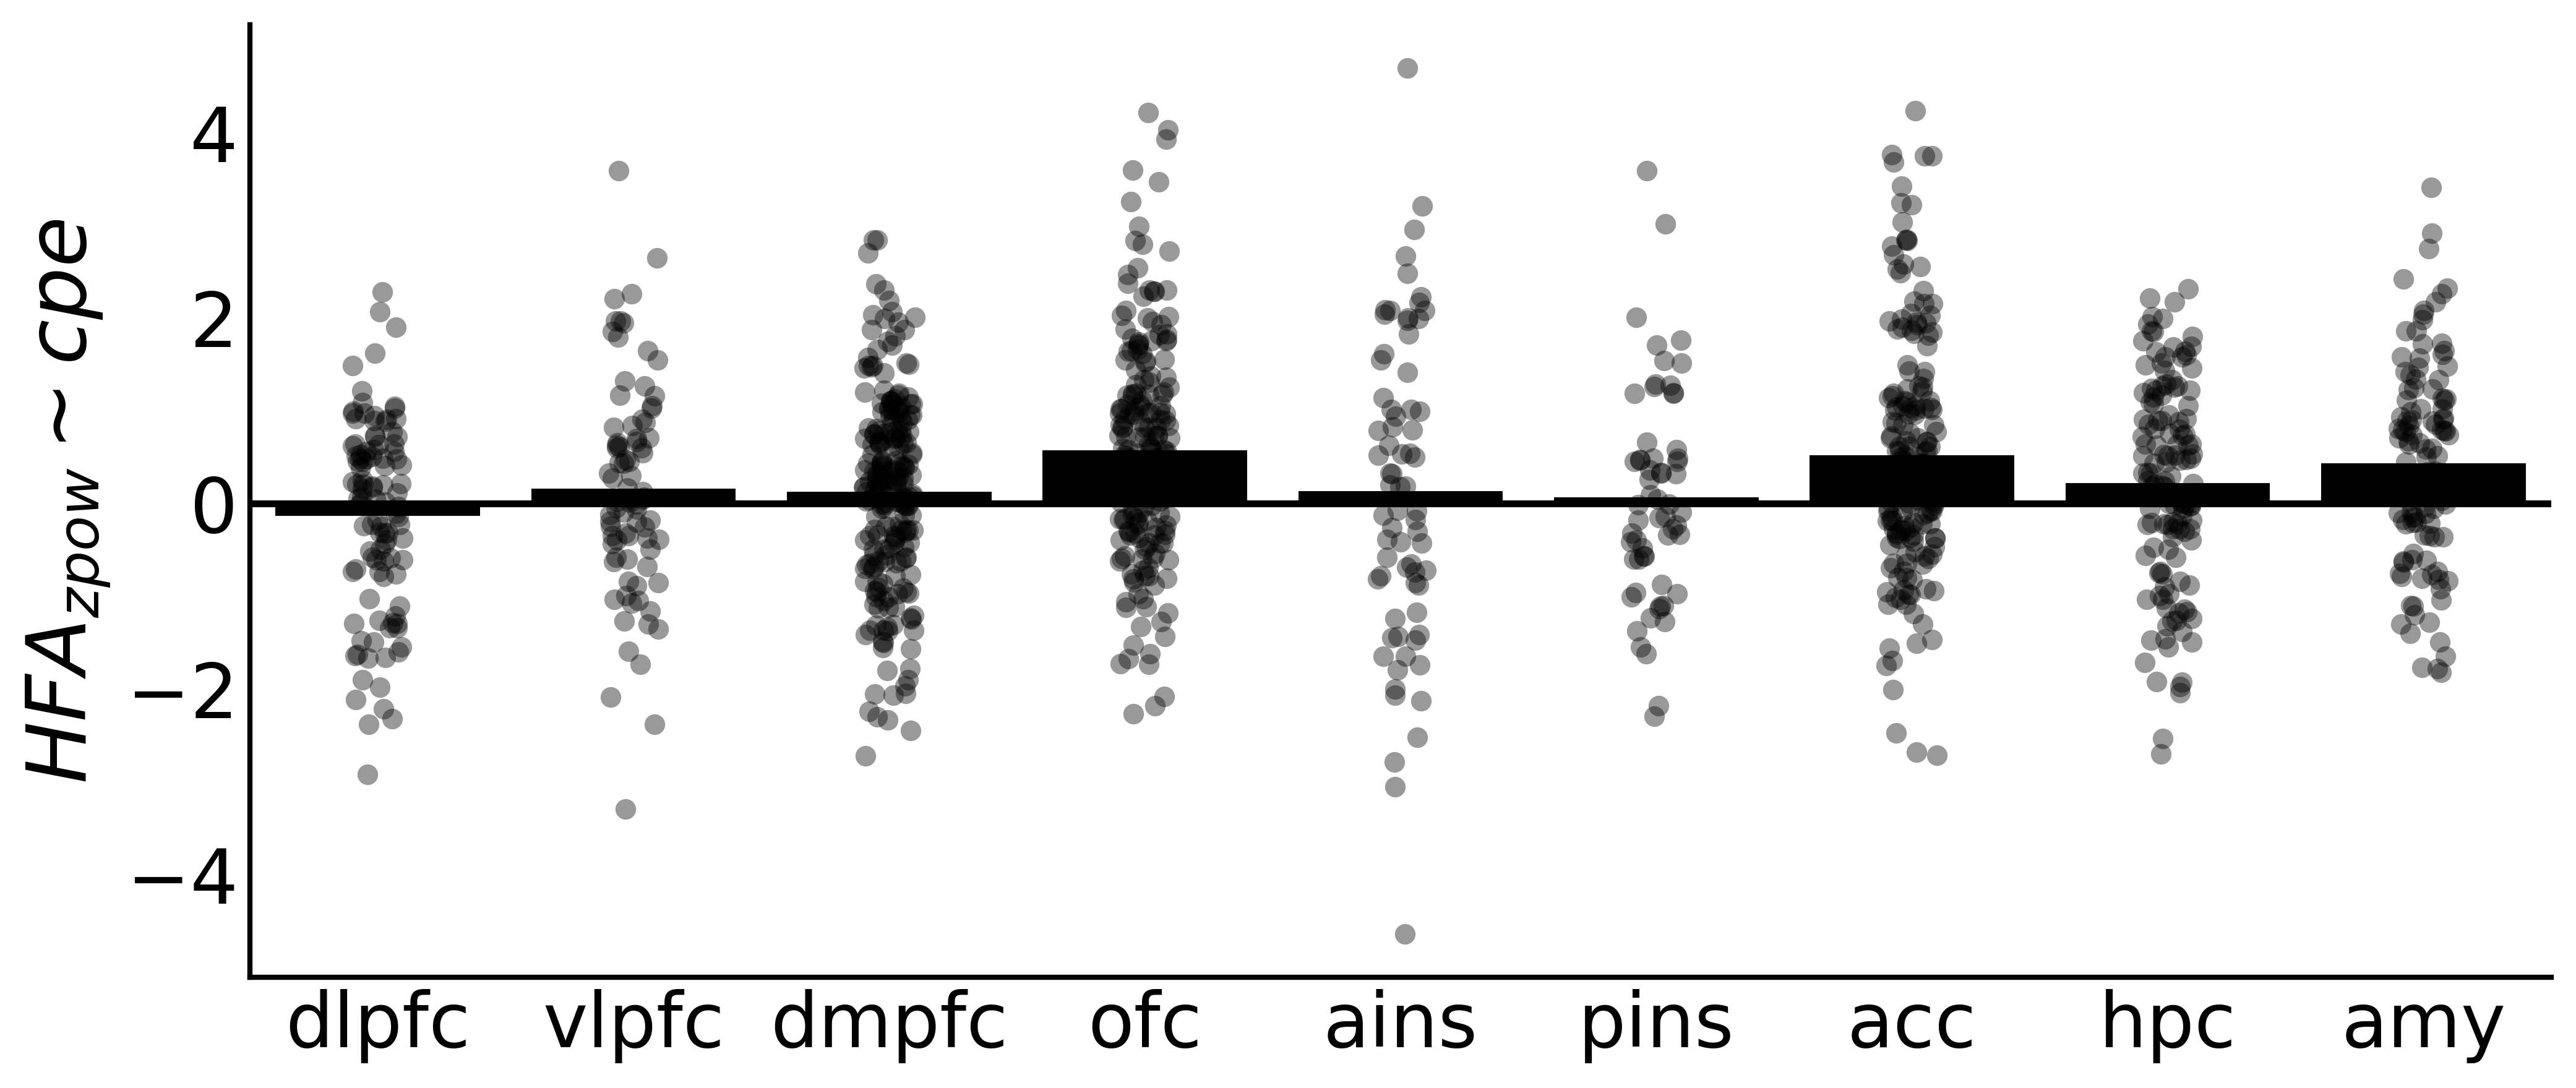

In [41]:
ylabel = fr'$HFA_{{zpow}} \sim cpe$'
fig_id = f'{band}_single_elec_roi_barplot.pdf'


plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



In [43]:
results.to_csv(f'{save_dir}{band}_single_elec_perm_results.csv')

In [28]:
# plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(13,4),color='k')
# green '#135546'


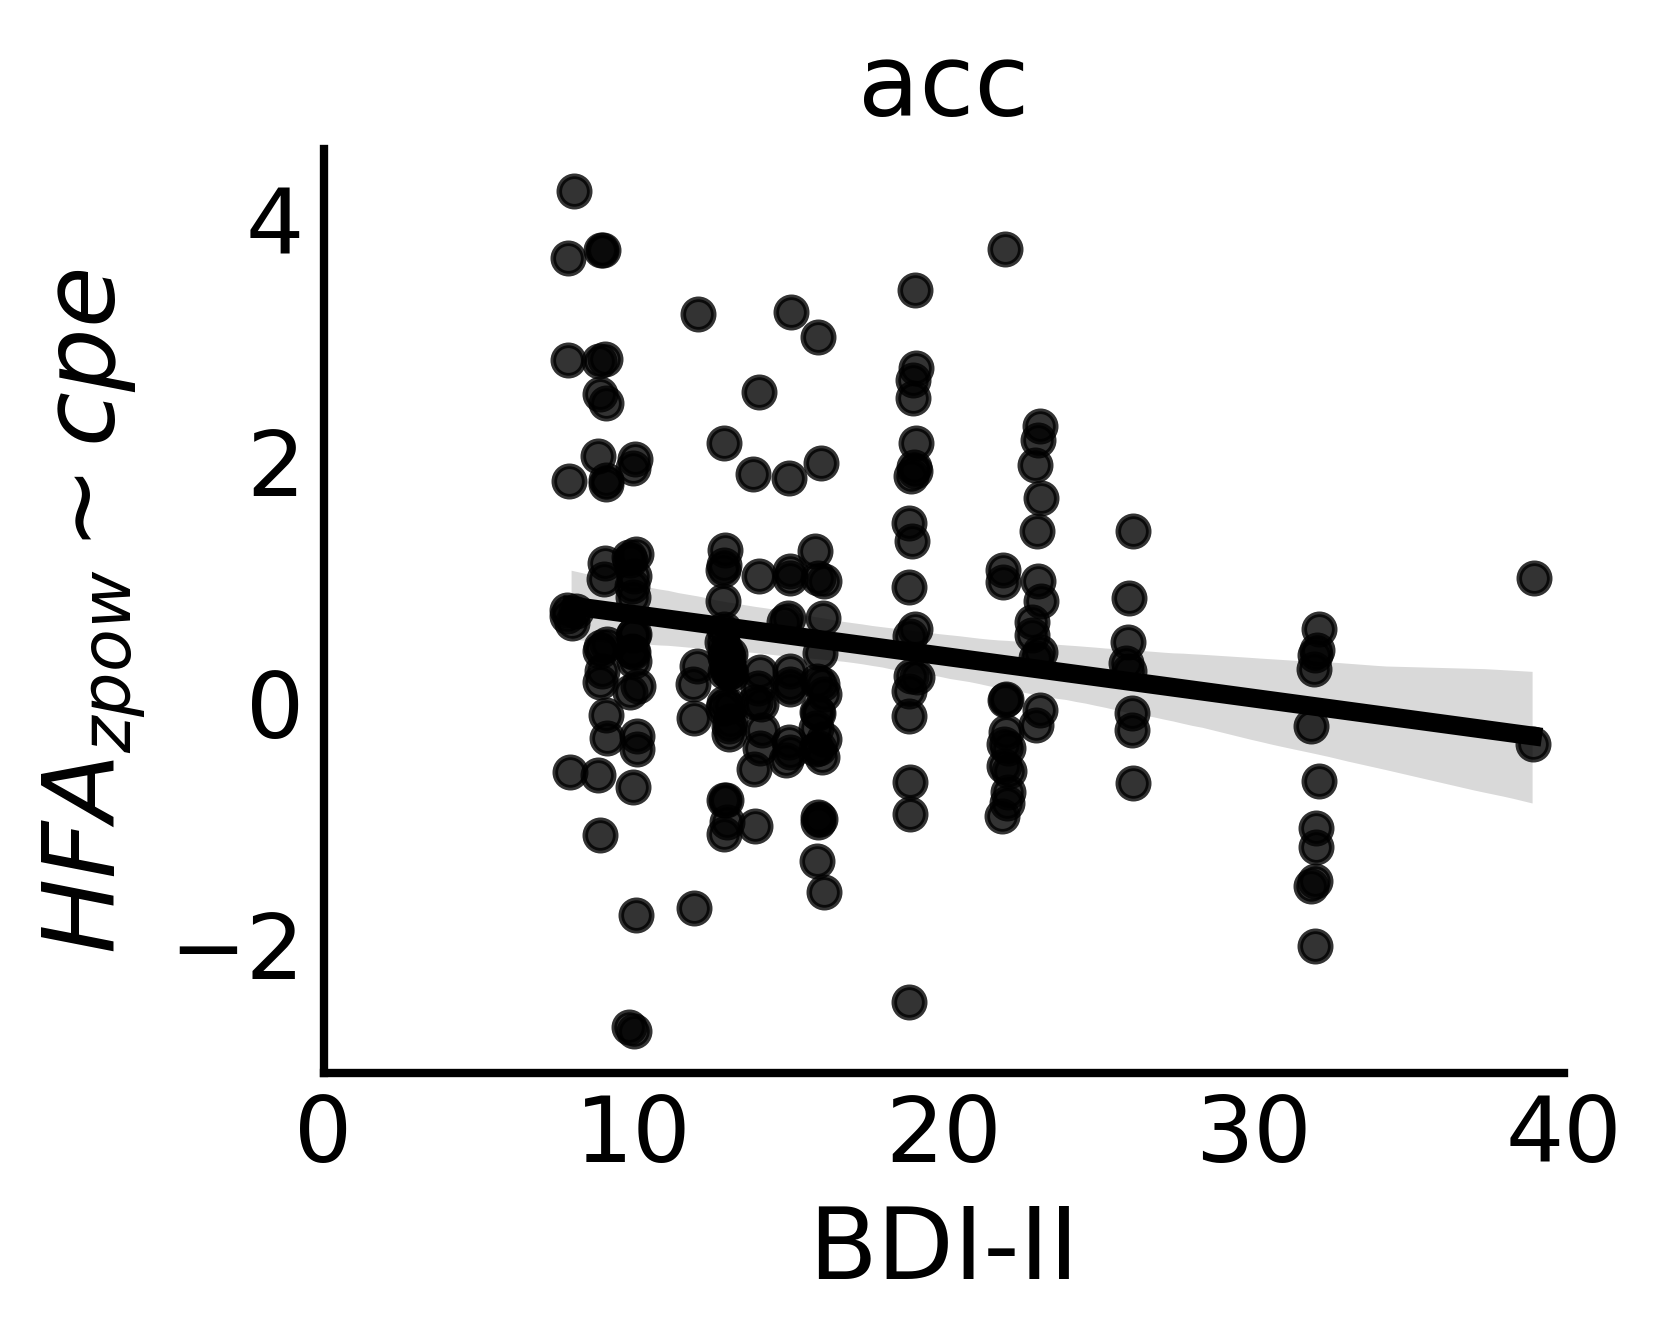

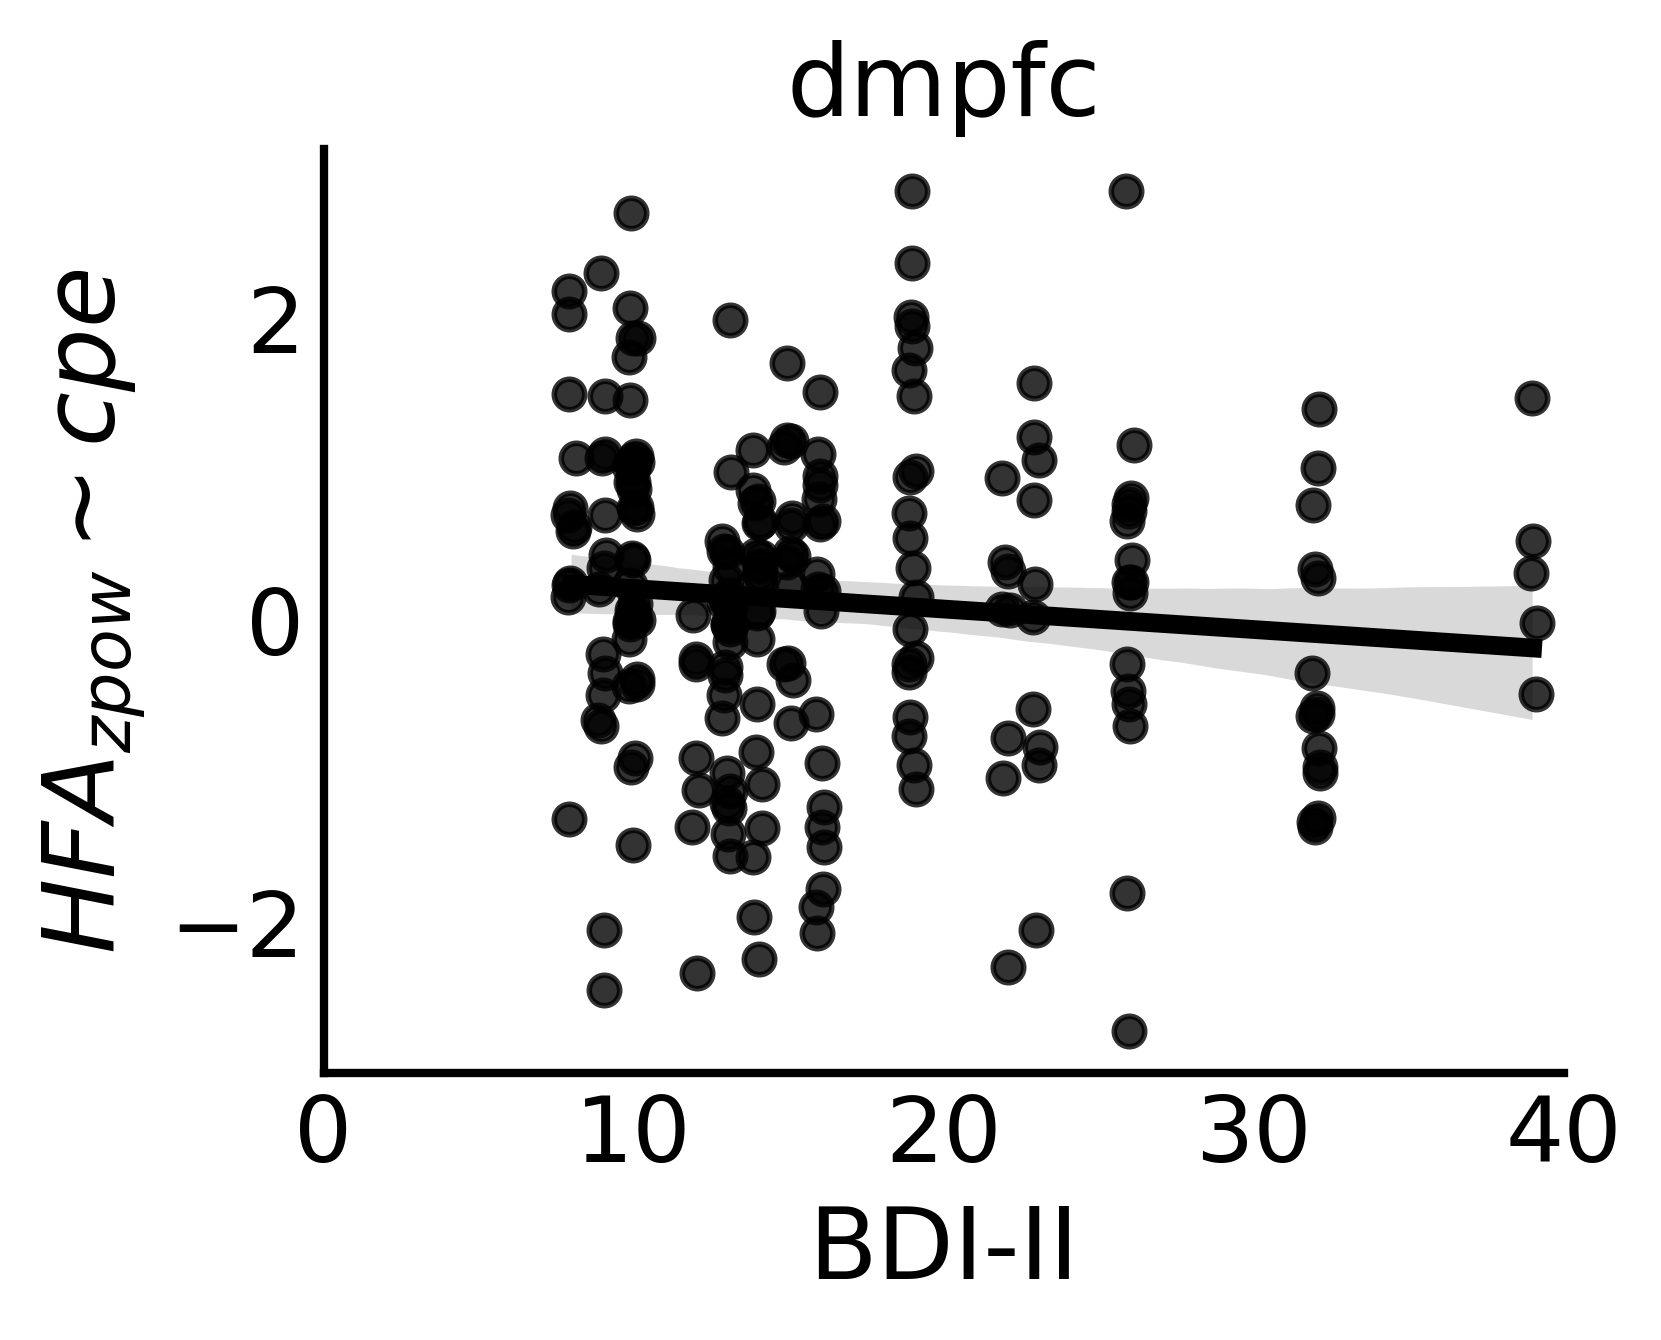

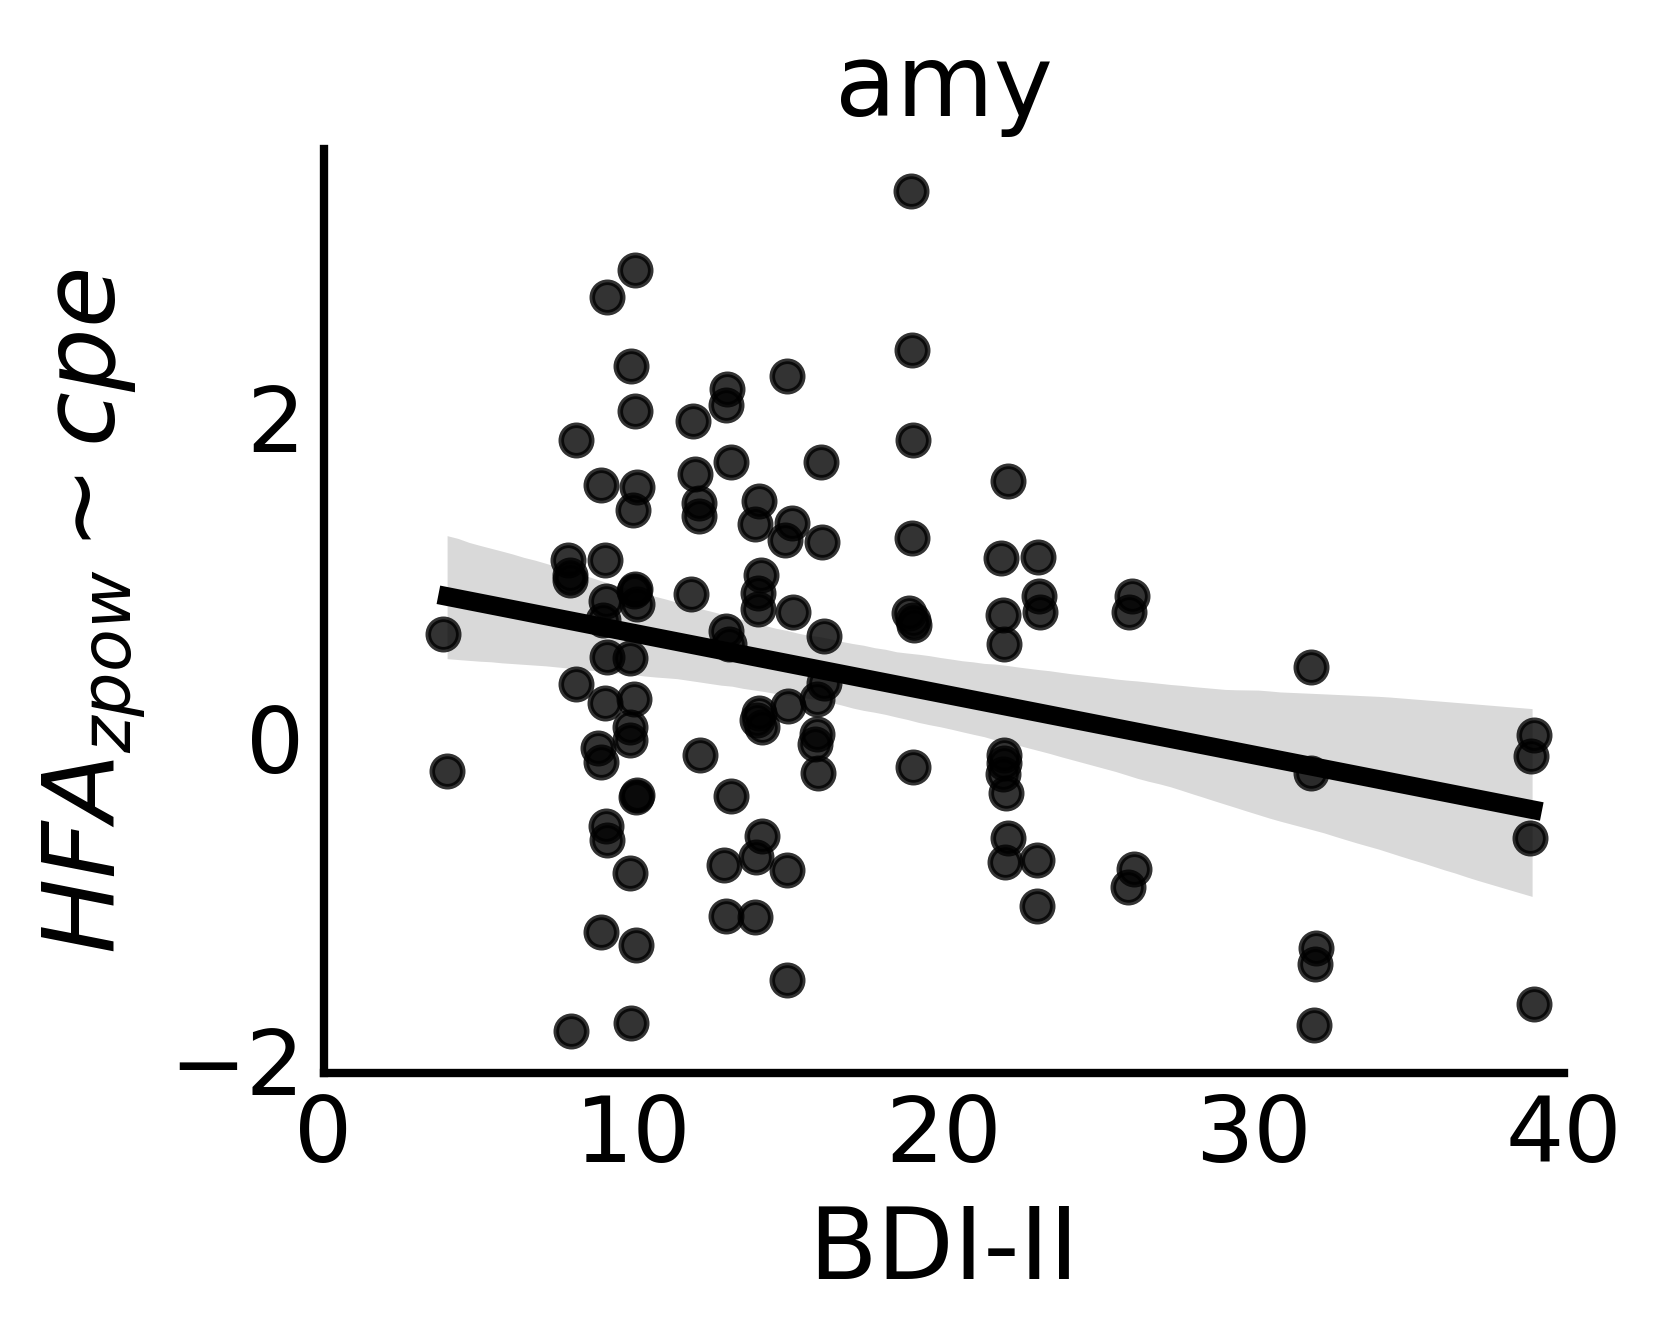

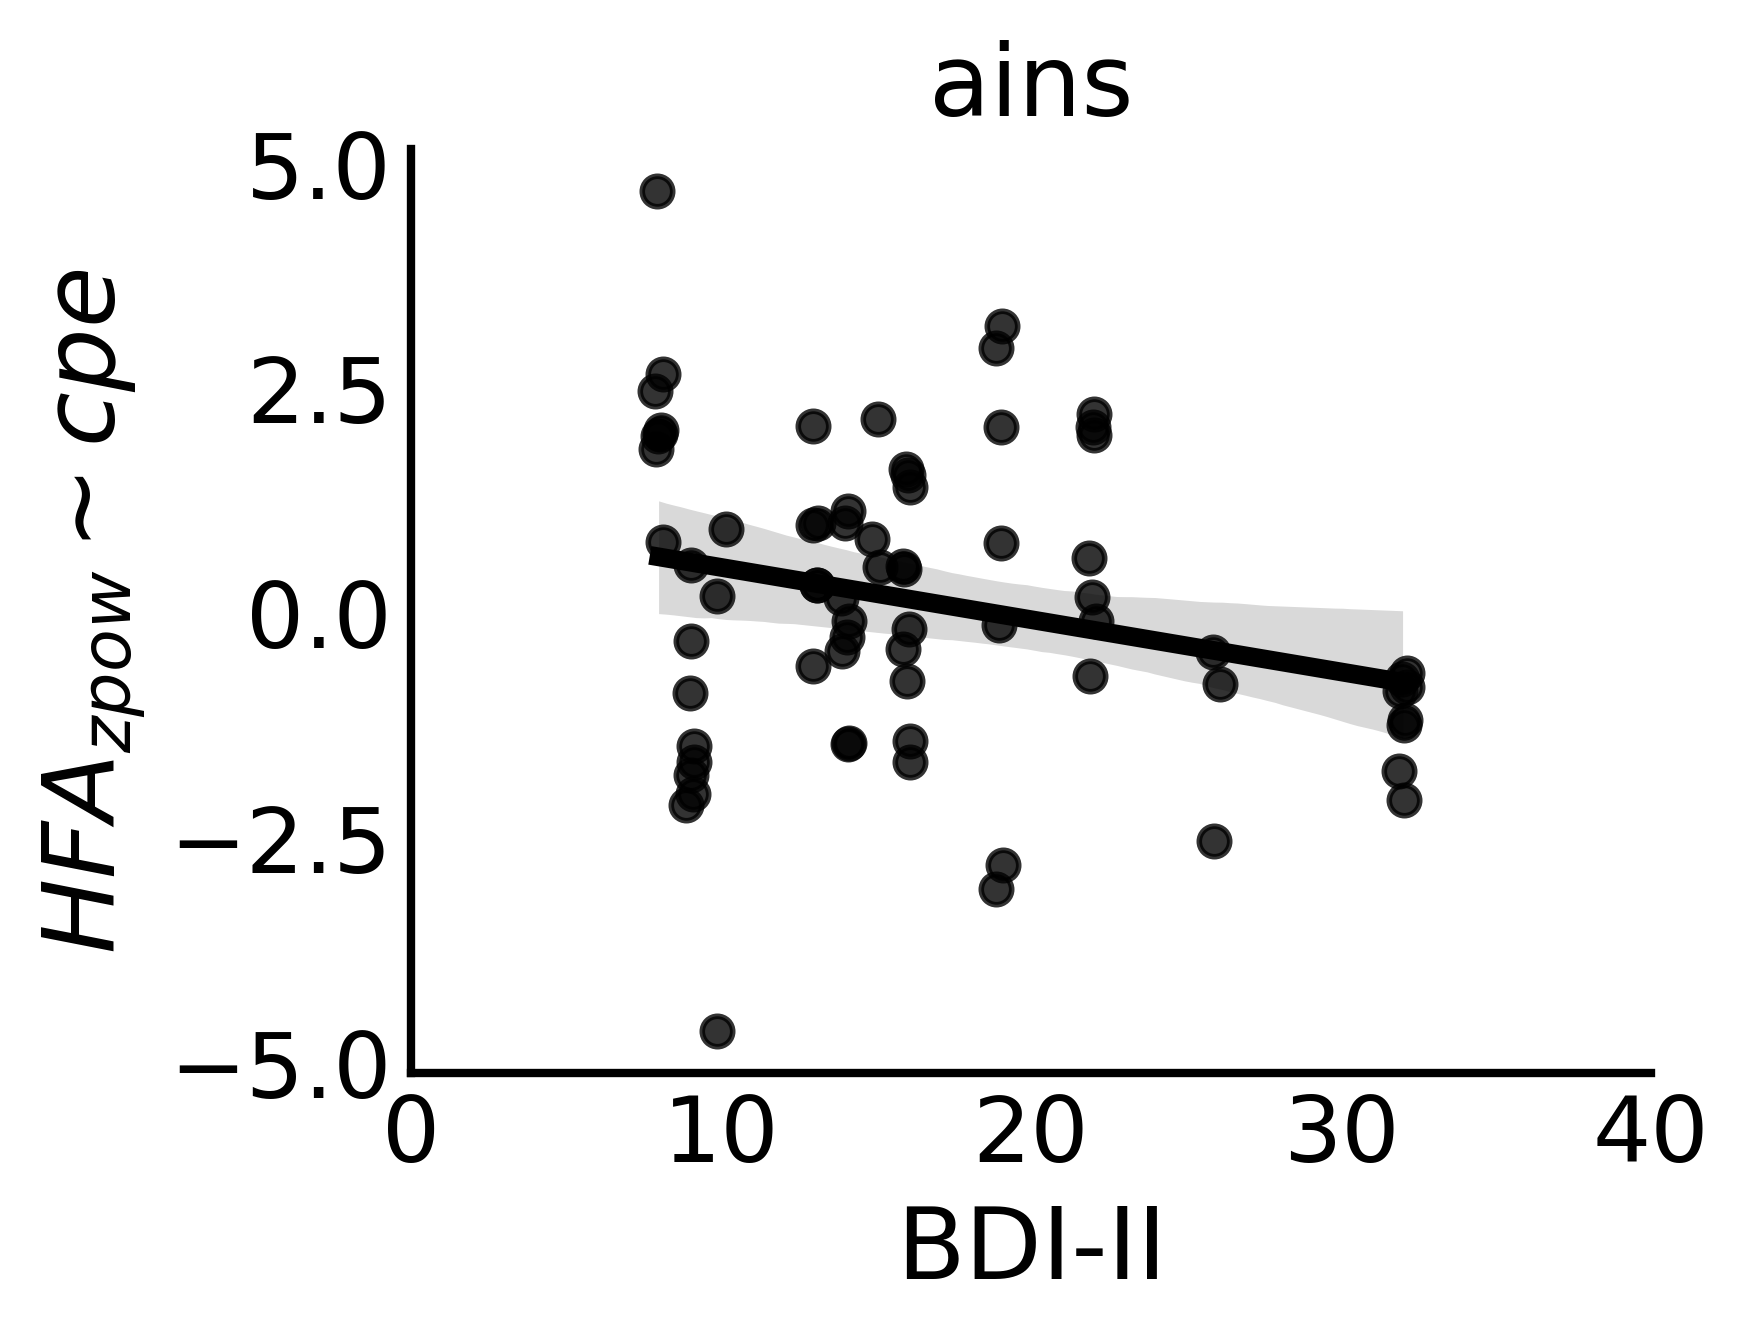

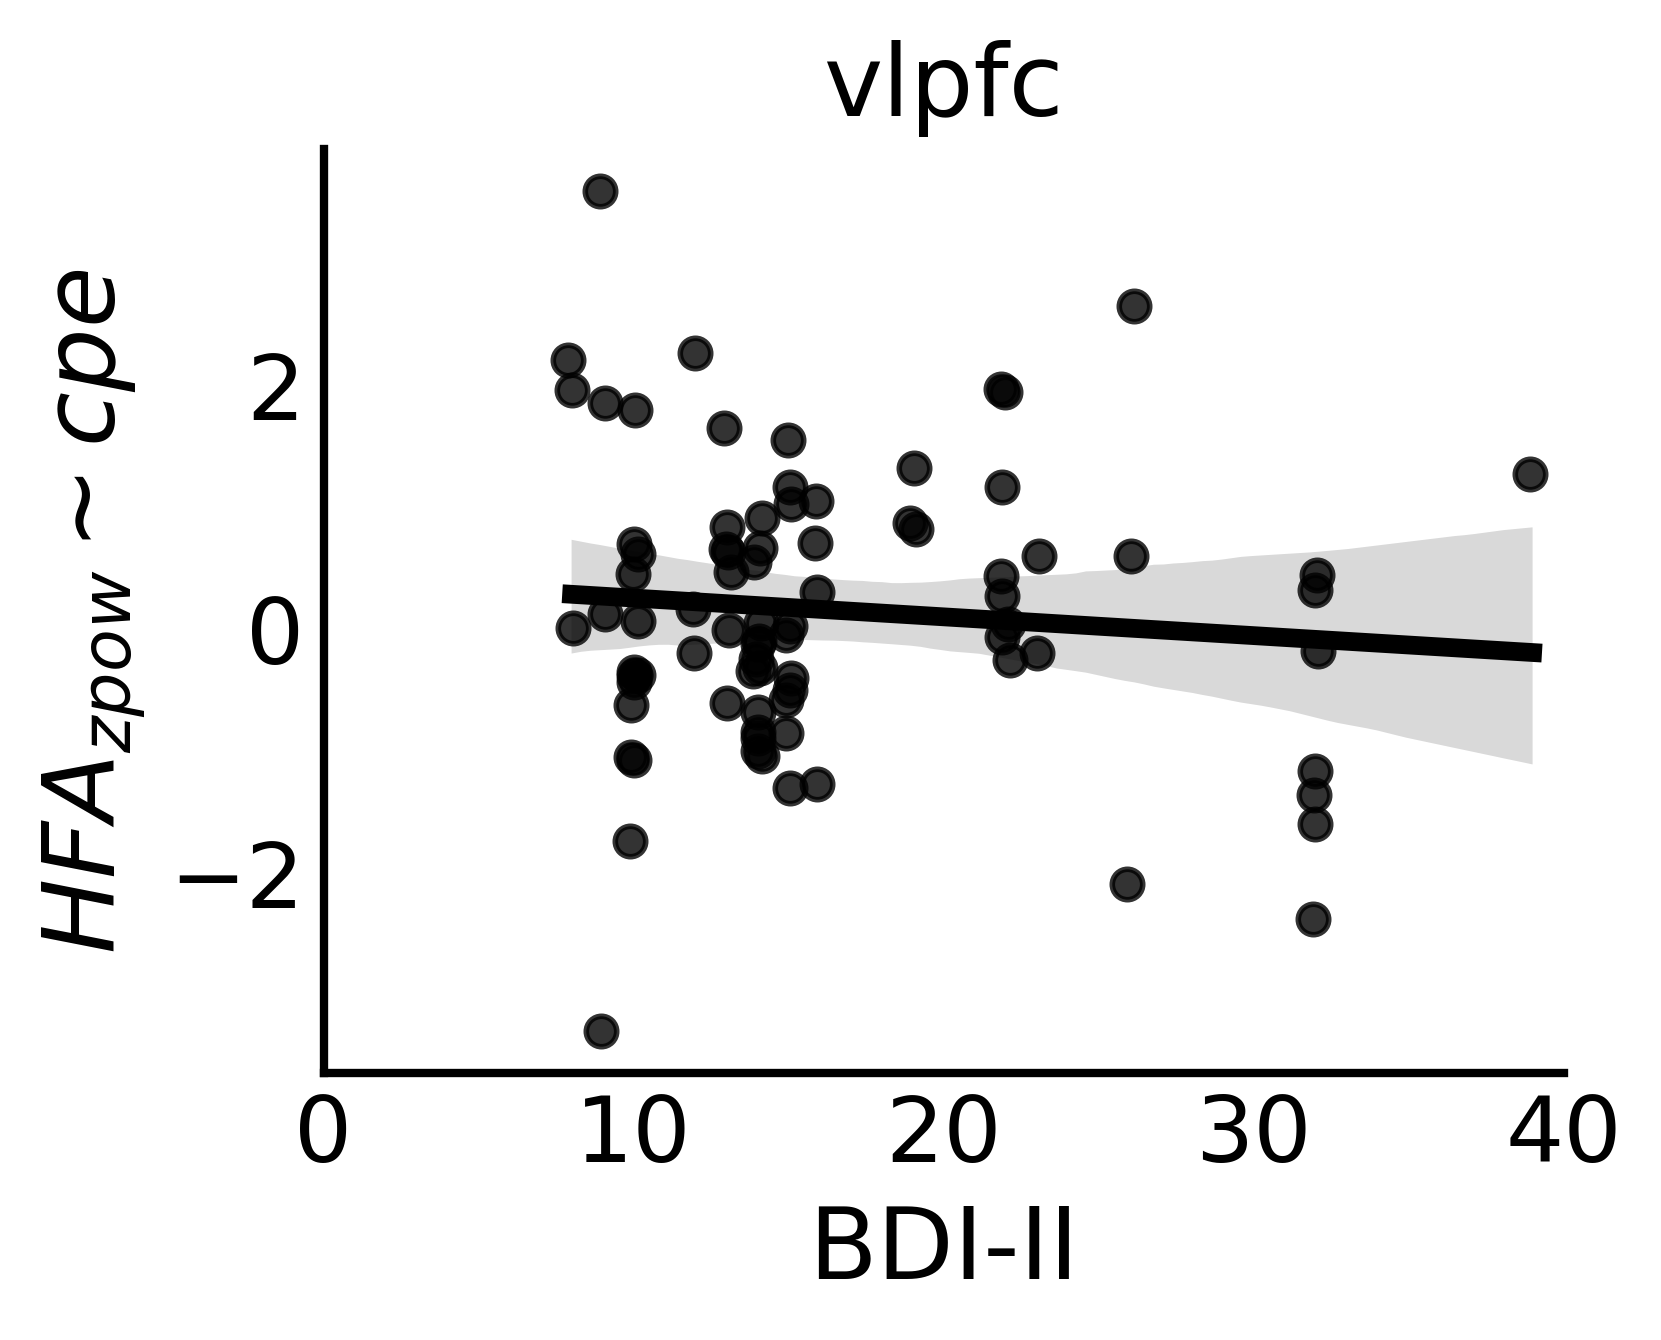

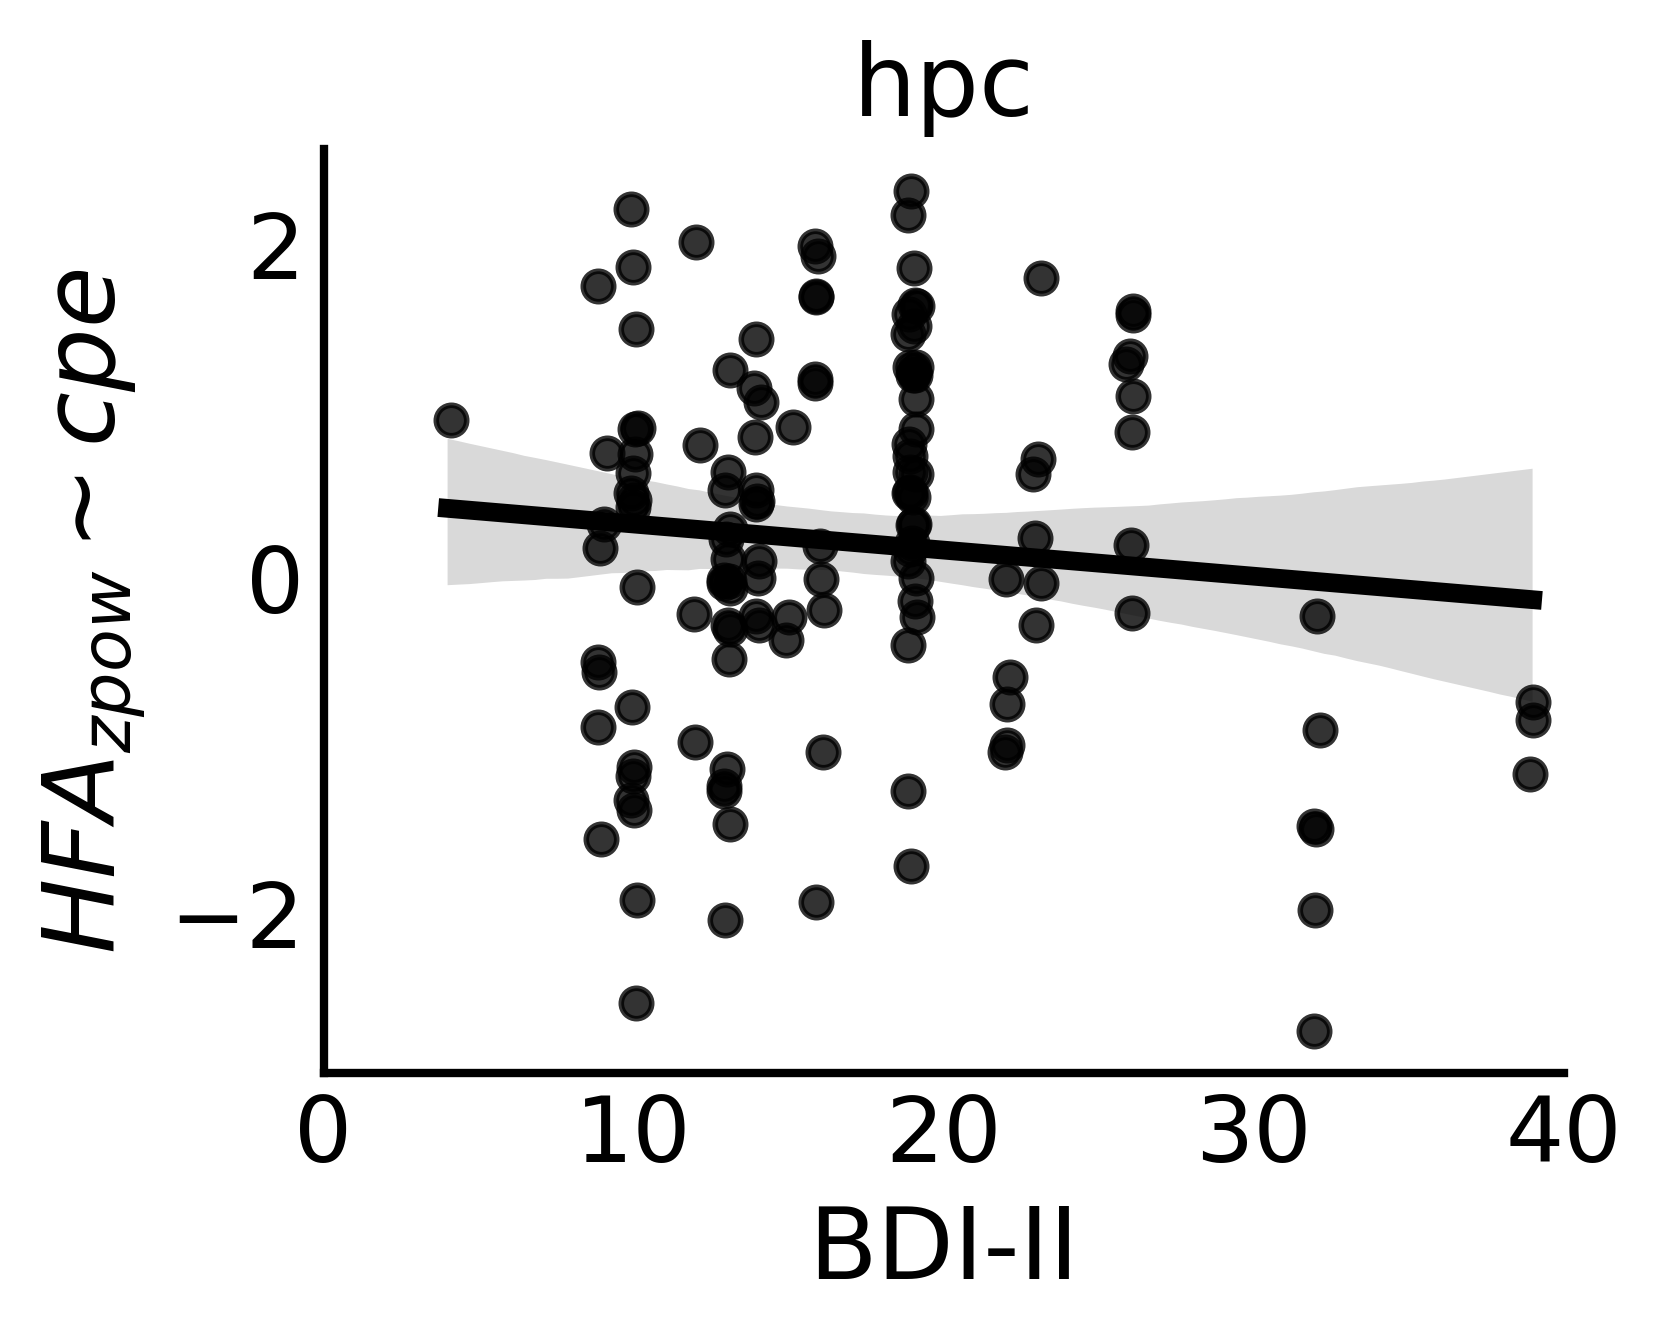

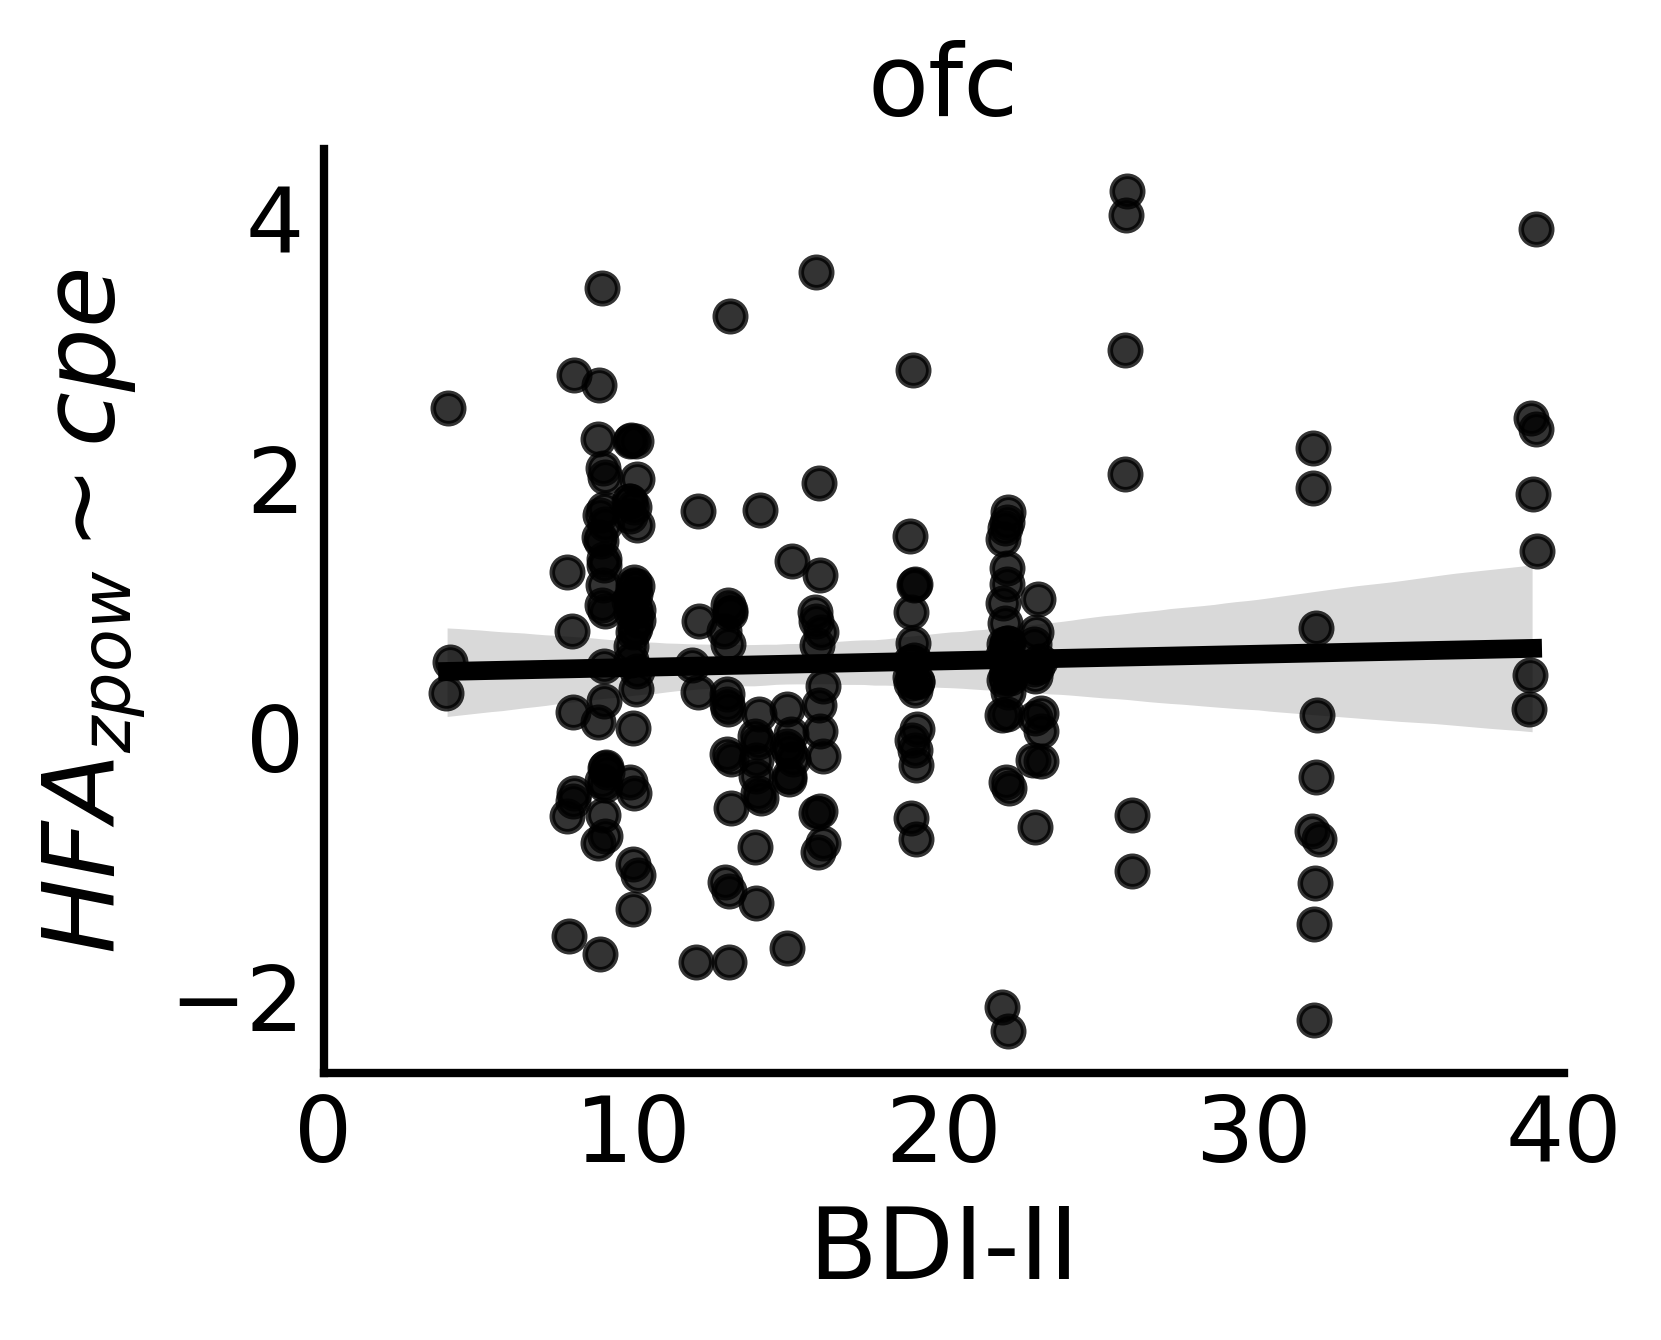

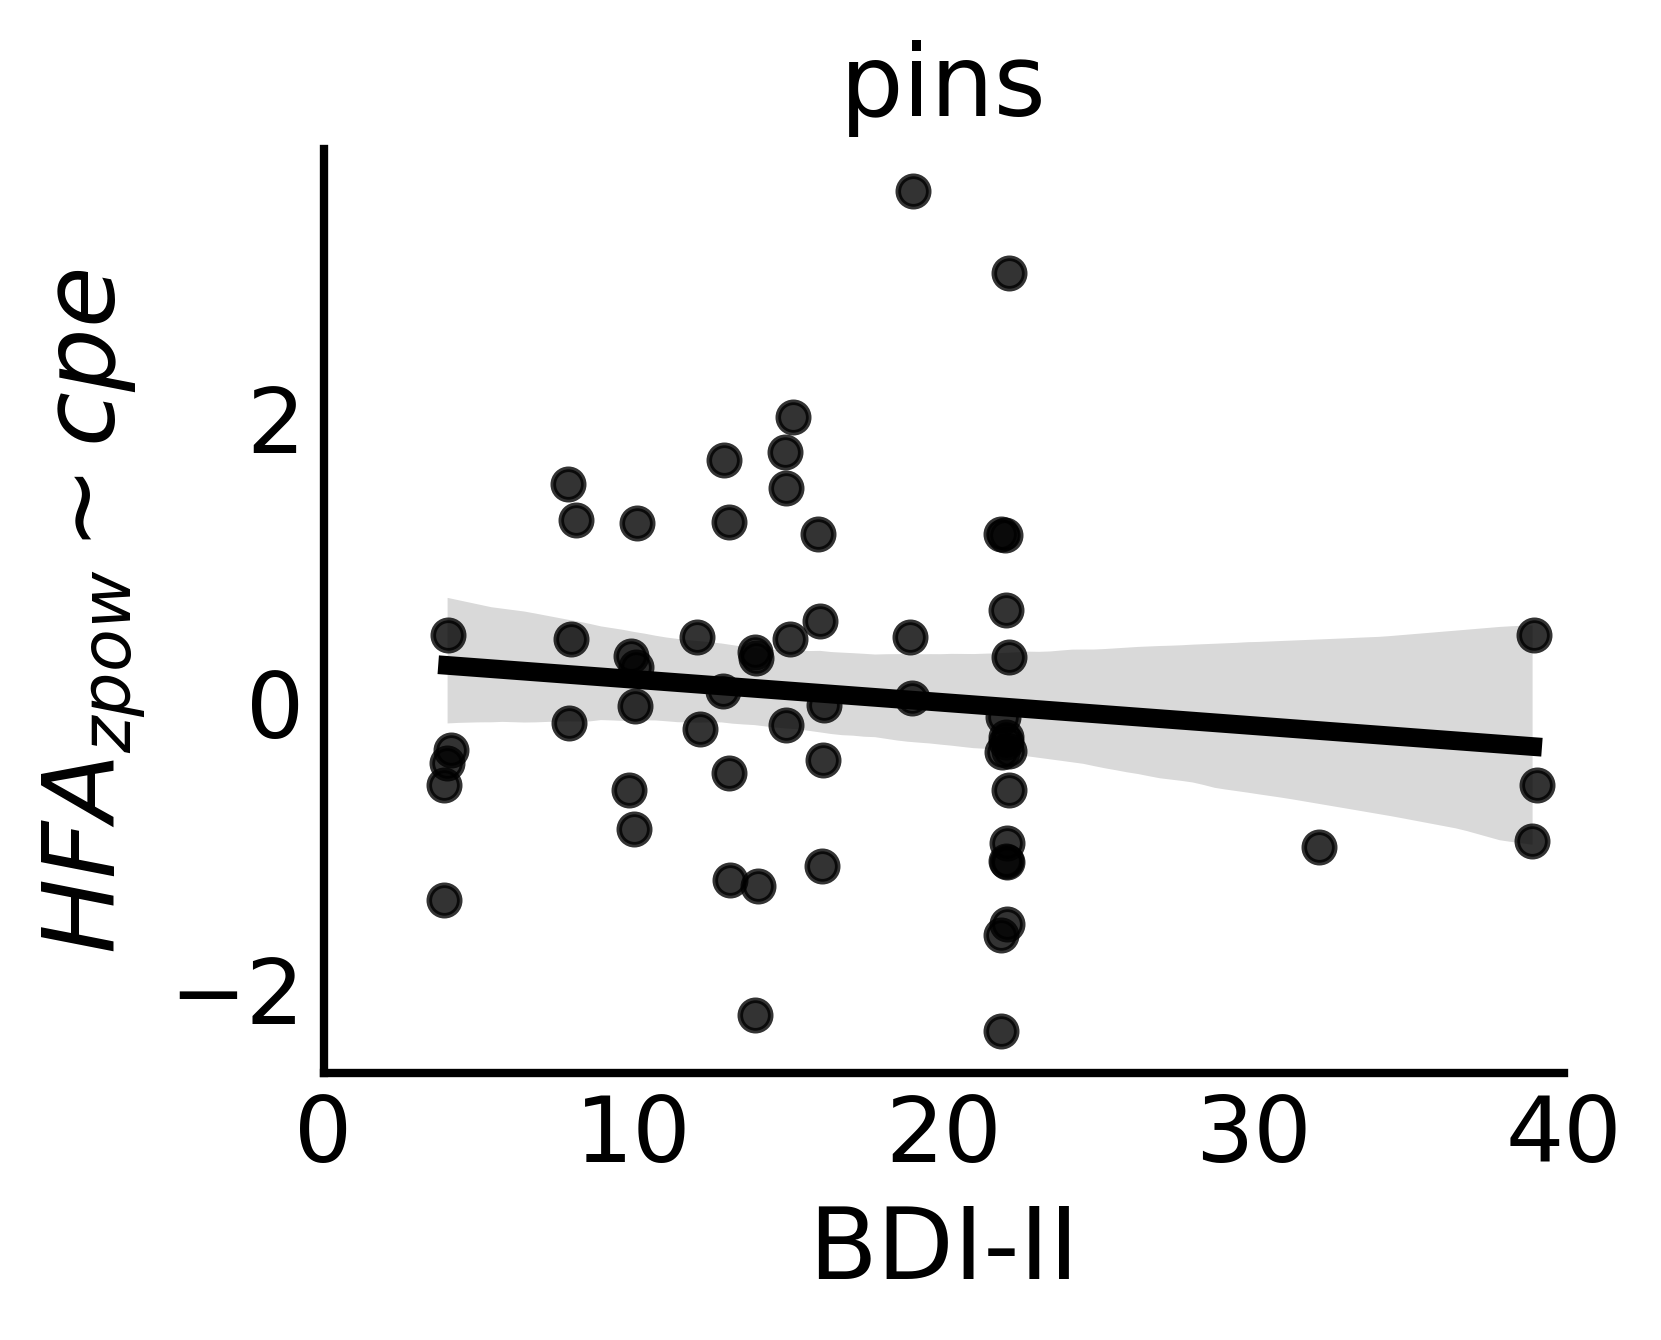

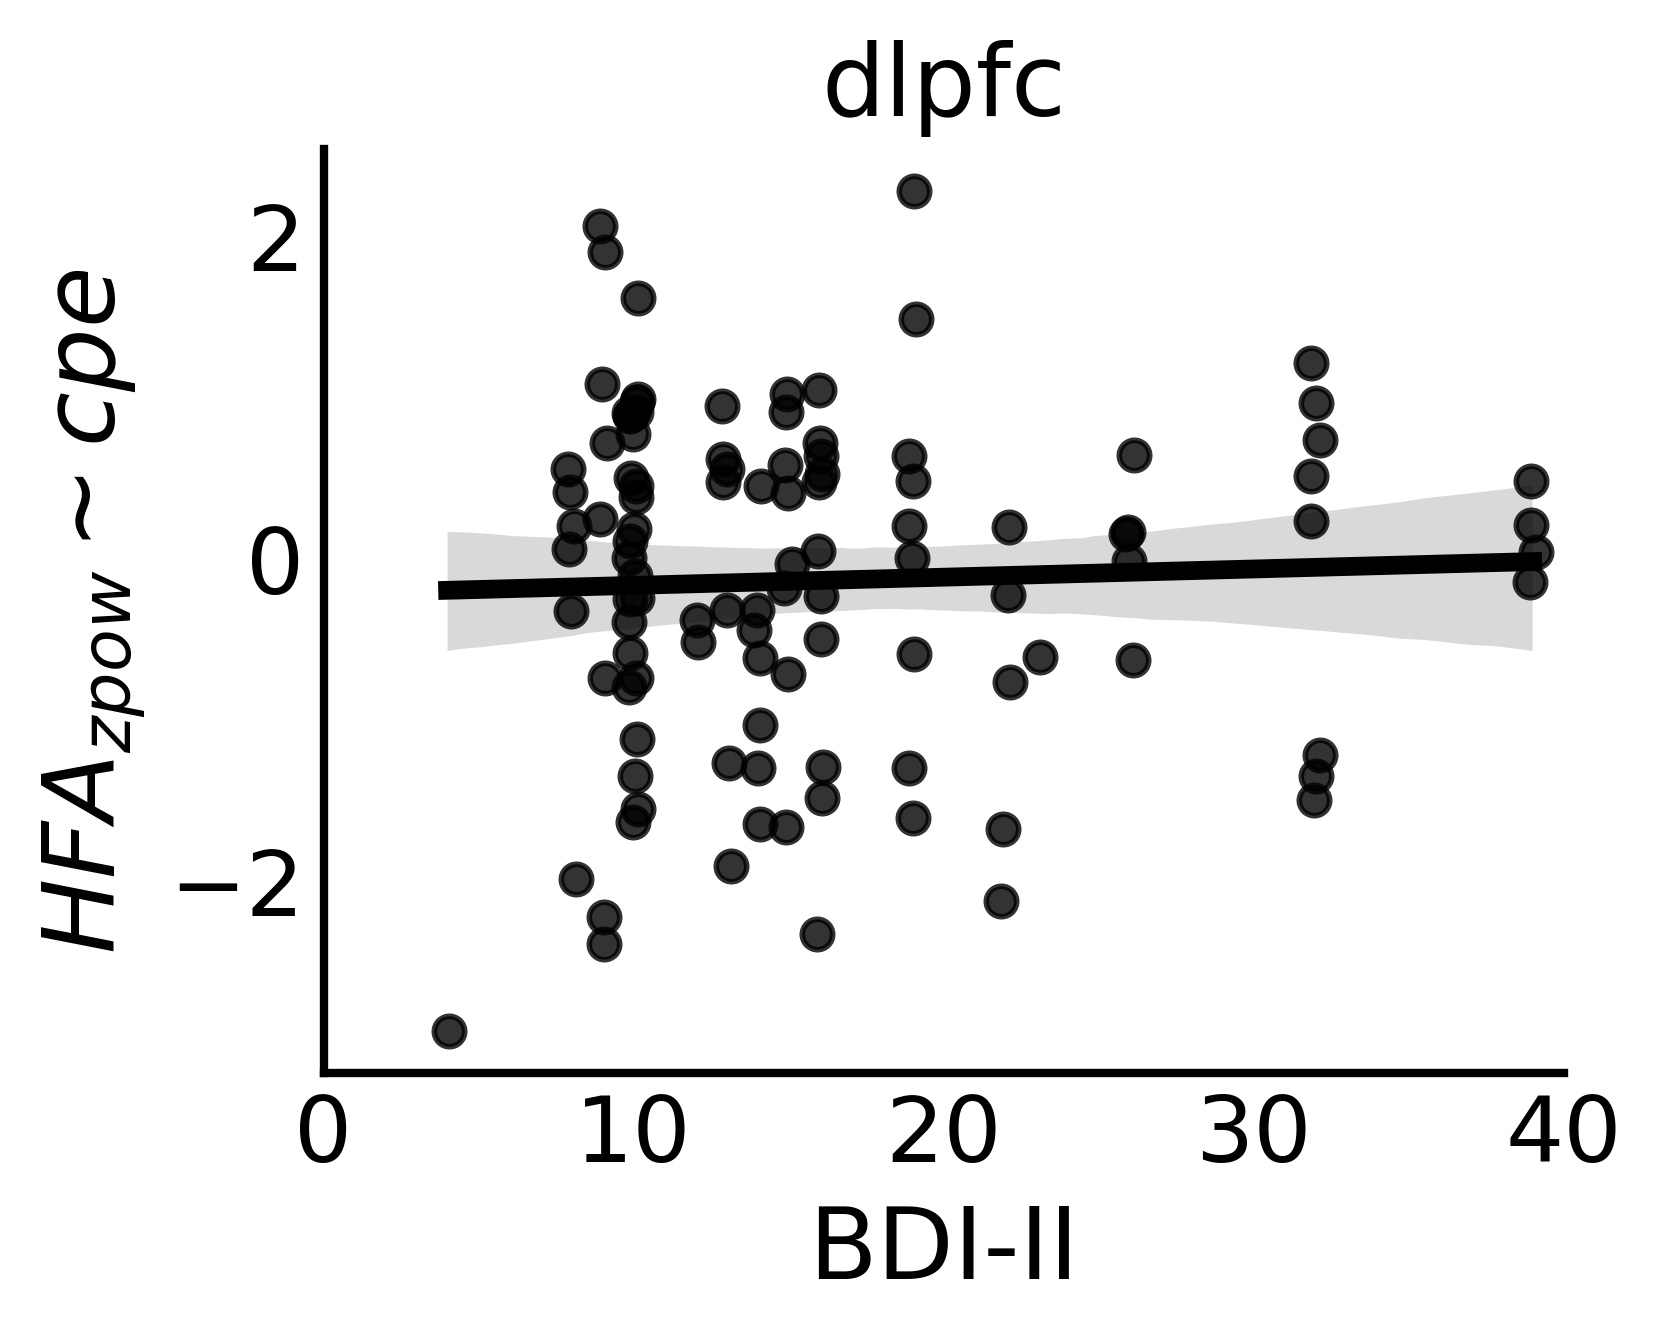

In [46]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'$HFA_{{zpow}} \sim cpe$')
    
    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [45]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 15 Sep 2024                                         
Time:                        23:43:08                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2335      0.479     33.871     

# Mixed effects models

In [47]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'cpe']
rand_vars    = ['GambleChoice','TotalProfit', 'cpe']


In [48]:
roi_fit_dict = {f'{roi}':fit_mixed_model(hfa_reg_df[hfa_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in hfa_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],hfa_reg_df[hfa_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [49]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [50]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['cpe'],4) for roi in fe_results.roi.tolist()]
# fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
# fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


Intercept  GambleChoice[T.safe]  GambleChoice[T.skip]  TotalProfit  \
0  -0.001397             -0.006013              0.194453    -0.012968   
1  -0.003854              0.004092              0.292416    -0.013046   
2  -0.009376              0.000654              0.260181     0.002477   
3   0.008704             -0.000451             -0.051928     0.002229   
4   0.001357              0.008318              0.181958    -0.008431   
5  -0.015438              0.000876              0.138991    -0.002682   
6  -0.004428              0.010667             -0.026864    -0.008000   
7  -0.012212             -0.000560              0.093809     0.001919   
8  -0.005724              0.011925              0.132795    -0.008362   

        cpe    roi  cpe_pval  
0  0.006383    acc    0.0000  
1  0.001770  dmpfc    0.1256  
2  0.004849    amy    0.0001  
3  0.001307   ains    0.6214  
4  0.002514  vlpfc    0.2725  
5  0.003463    hpc    0.0071  
6  0.008093    ofc    0.0000  
7  0.000140   pins    0.9460  
8 -0.000835  dlpfc    0.6694

In [52]:
fe_results.set_index('roi')

Intercept  GambleChoice[T.safe]  GambleChoice[T.skip]  TotalProfit  \
roi                                                                         
acc    -0.001397             -0.006013              0.194453    -0.012968   
dmpfc  -0.003854              0.004092              0.292416    -0.013046   
amy    -0.009376              0.000654              0.260181     0.002477   
ains    0.008704             -0.000451             -0.051928     0.002229   
vlpfc   0.001357              0.008318              0.181958    -0.008431   
hpc    -0.015438              0.000876              0.138991    -0.002682   
ofc    -0.004428              0.010667             -0.026864    -0.008000   
pins   -0.012212             -0.000560              0.093809     0.001919   
dlpfc  -0.005724              0.011925              0.132795    -0.008362   

            cpe  cpe_pval  
roi                        
acc    0.006383    0.0000  
dmpfc  0.001770    0.1256  
amy    0.004849    0.0001  
ains   0.001307    0.6214  
vlpfc  0.002514    0.2725  
hpc    0.003463    0.0071  
ofc    0.008093    0.0000  
pins   0.000140    0.9460  
dlpfc -0.000835    0.6694

In [53]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha



0.005555555555555556

In [54]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois



['acc', 'amy', 'ofc']

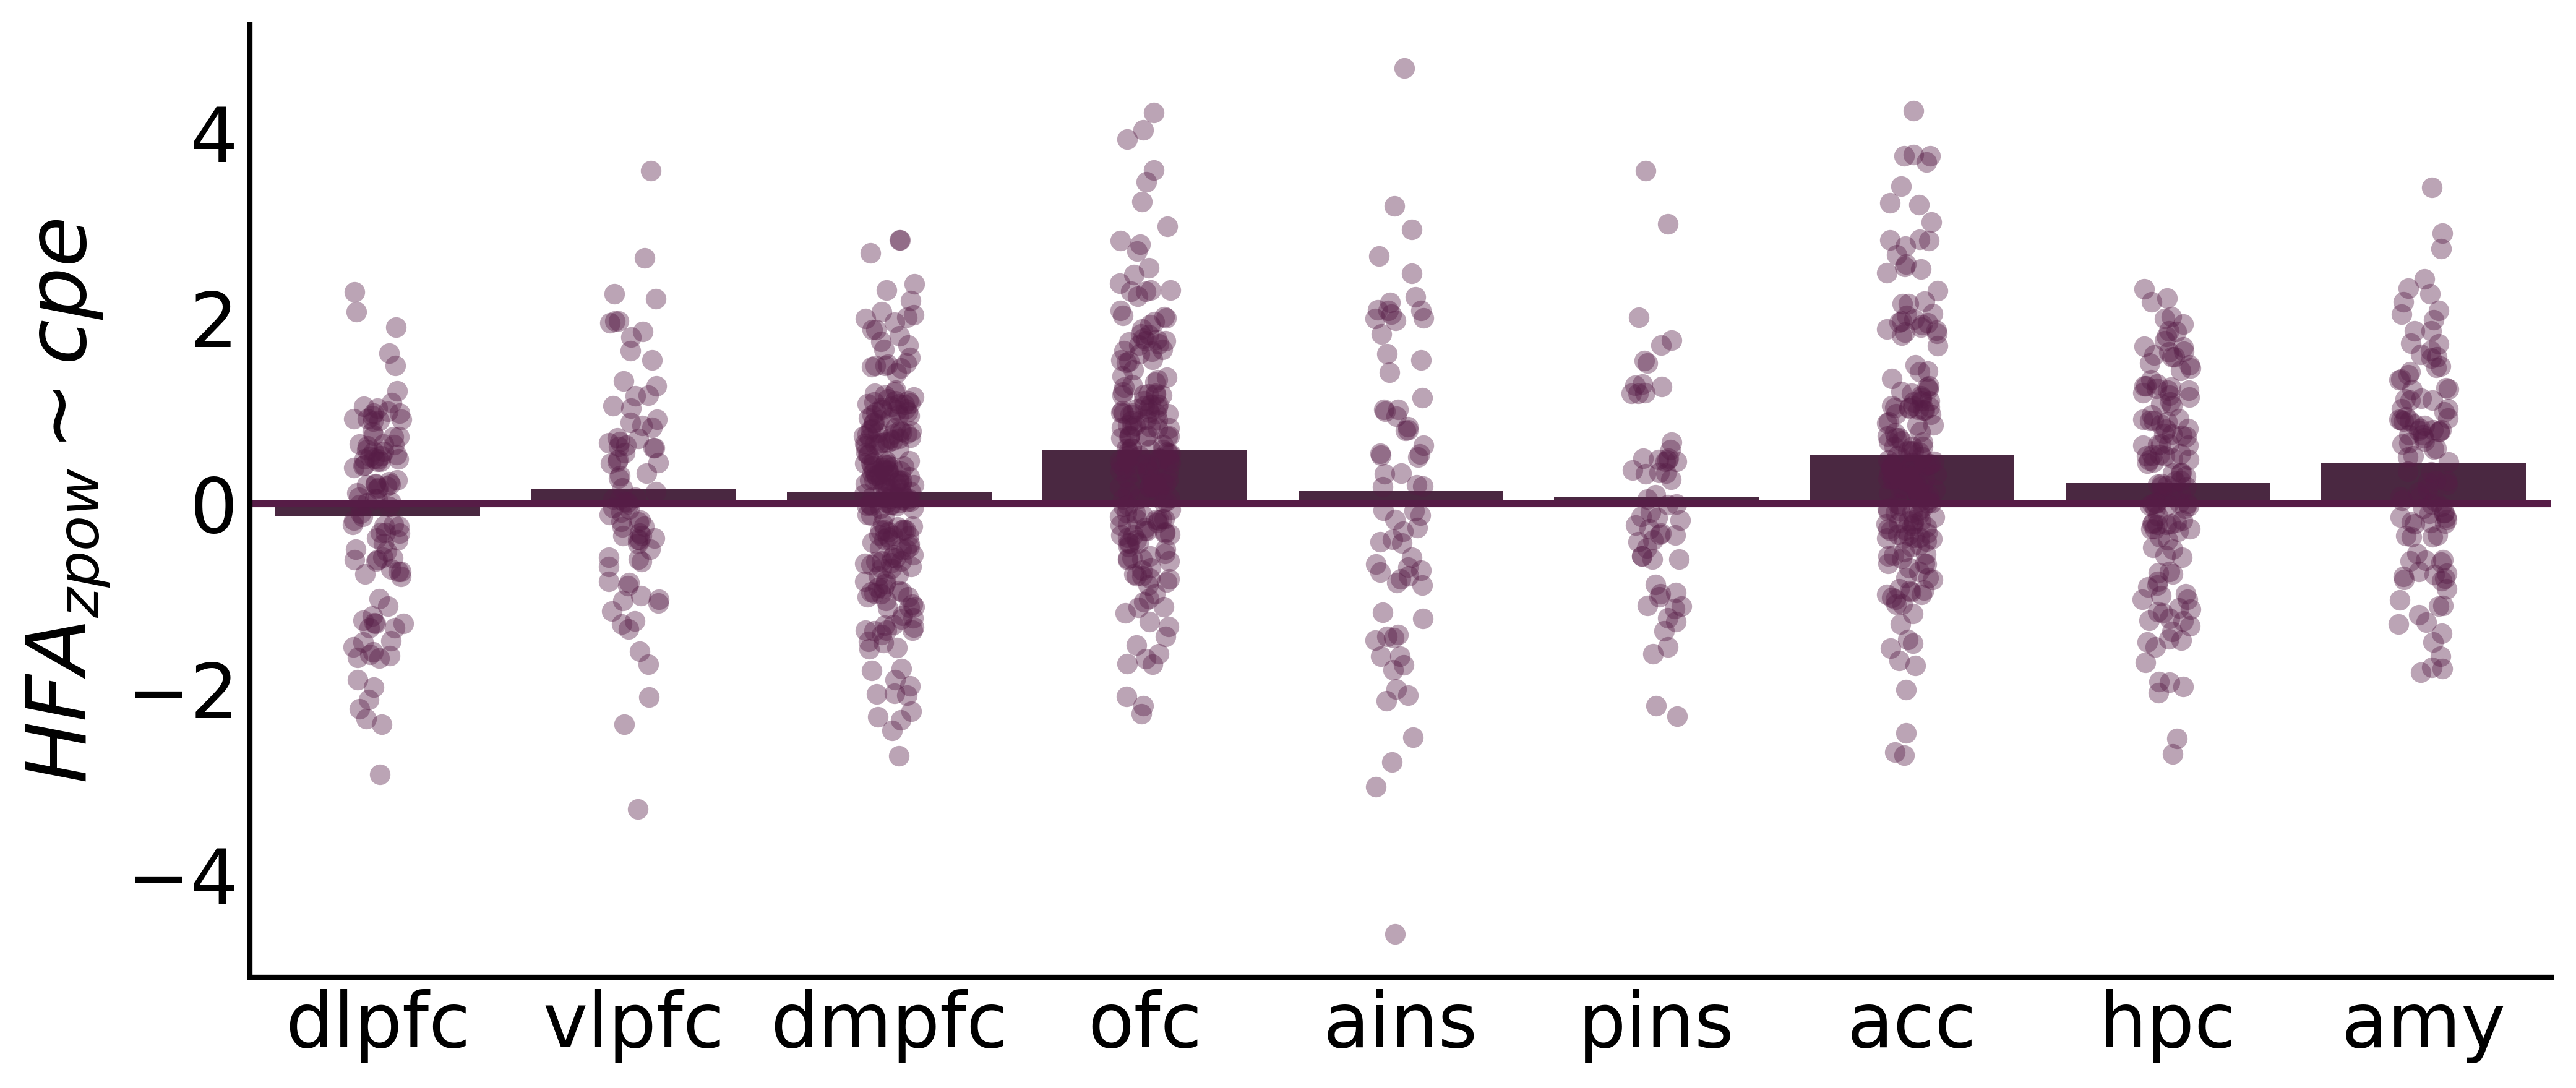

In [56]:
ylabel = fr'$HFA_{{zpow}} \sim cpe$'
fig_id = f'{band}_mlm_roi_barplot.pdf'


plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='#561C46',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



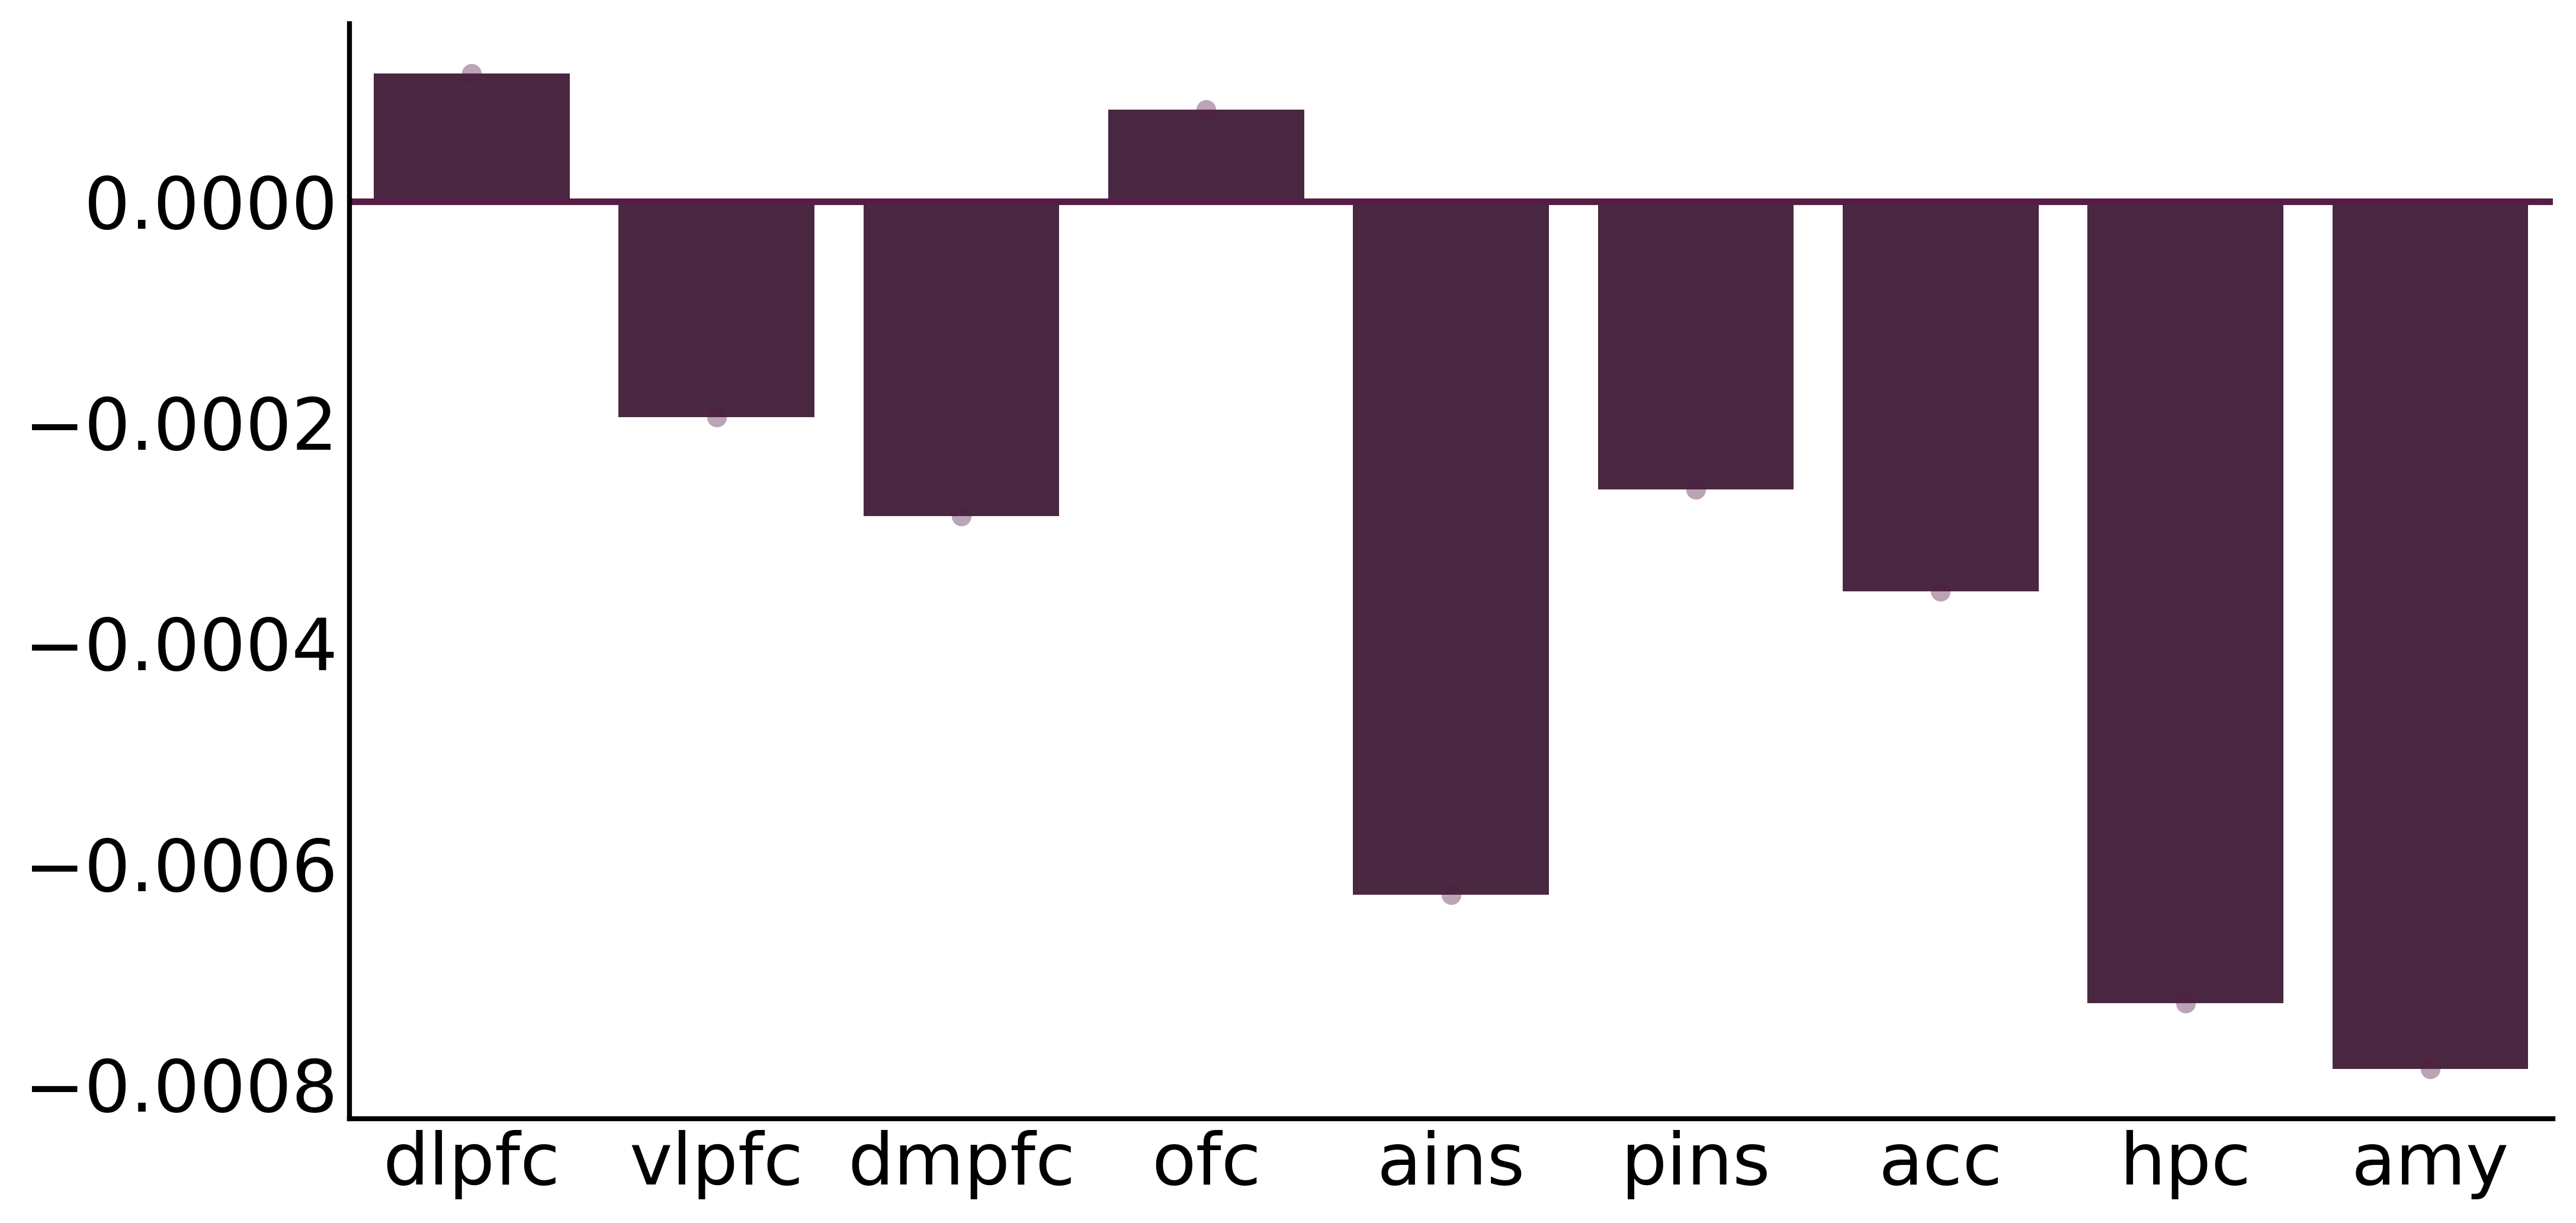

In [41]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#561C46')
# add to slides 


# BDI Correlation

In [64]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.07353512951876999 0.30947556287497874
dmpfc pearsonr 0.07995754182096386 0.23224471455880522
amy pearsonr -0.38580285208211196 2.441730266701212e-05
ains pearsonr -0.25268560164757525 0.03350274062281976
vlpfc pearsonr -0.135835142425927 0.22367839487976685
hpc pearsonr -0.1018445732283739 0.23984180059212762
ofc pearsonr 0.09188527712678474 0.1934009307924553
pins pearsonr 0.07180086855936052 0.5856351909706529
dlpfc pearsonr -0.040006280753820414 0.6824432173717793


In [65]:
sig_rho

[('amy', -0.38580285208211196, 2.441730266701212e-05),
 ('ains', -0.25268560164757525, 0.03350274062281976)]

In [63]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in roi_fit_results.roi.unique().tolist():
    roi_df = roi_fit_results[roi_fit_results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 15 Sep 2024                                         
Time:                        23:52:42                                         
No. Iterations:                     9                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5999      1.250     13.282     

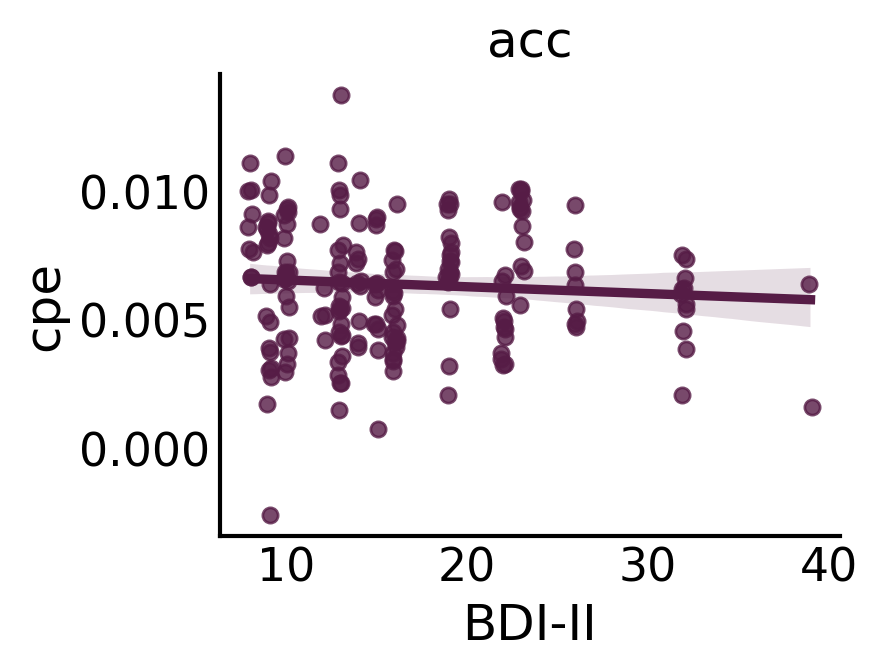

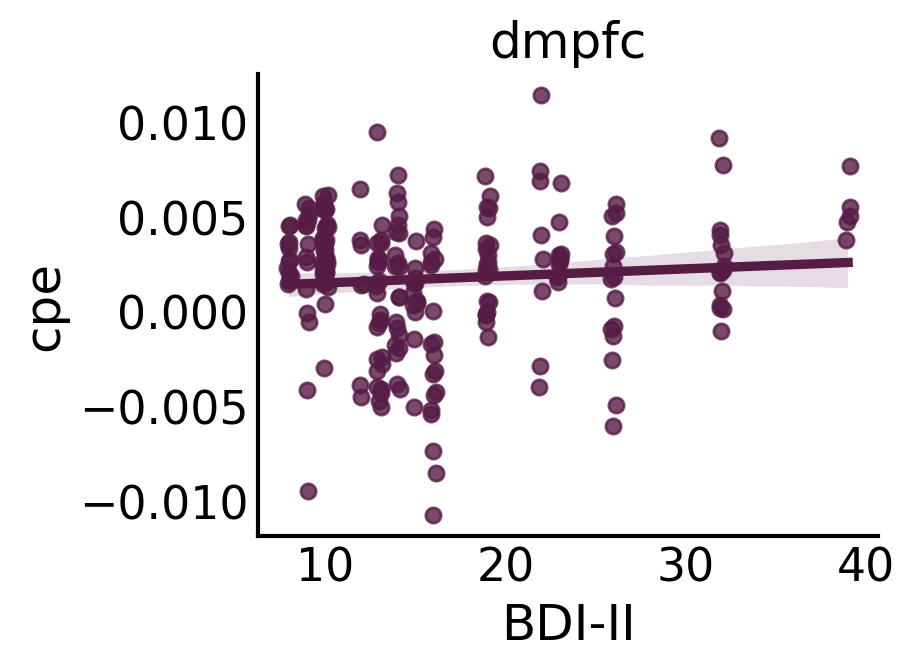

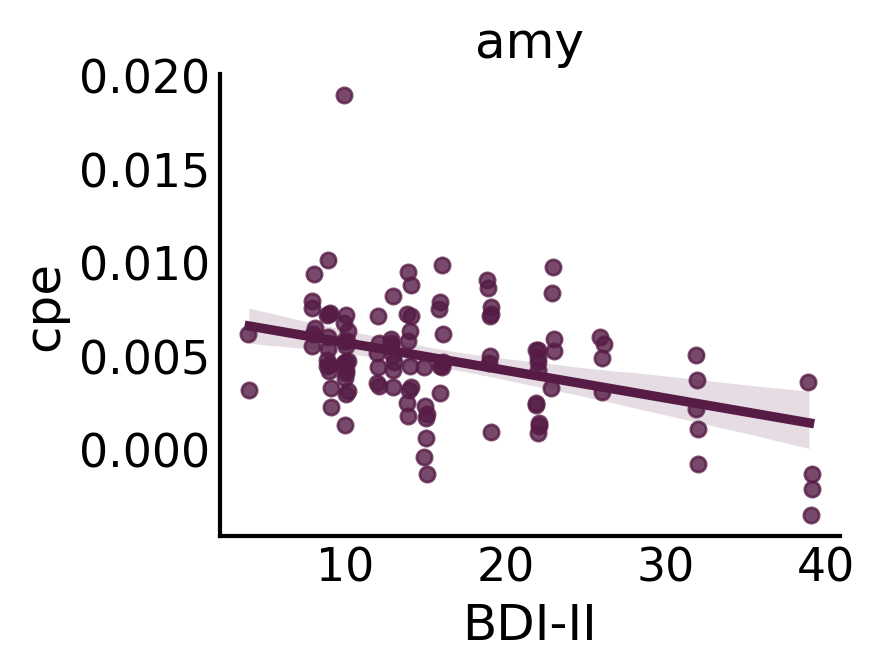

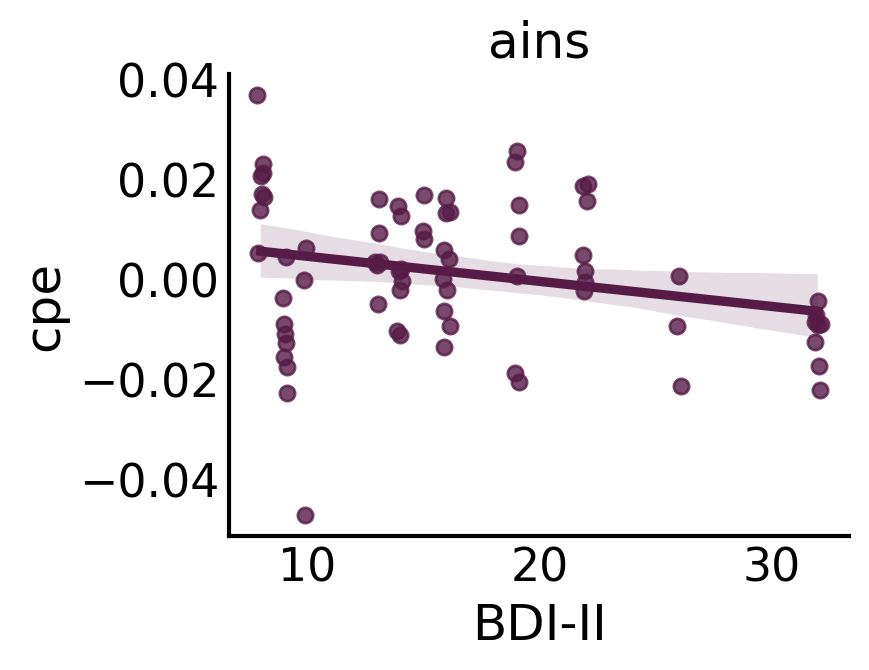

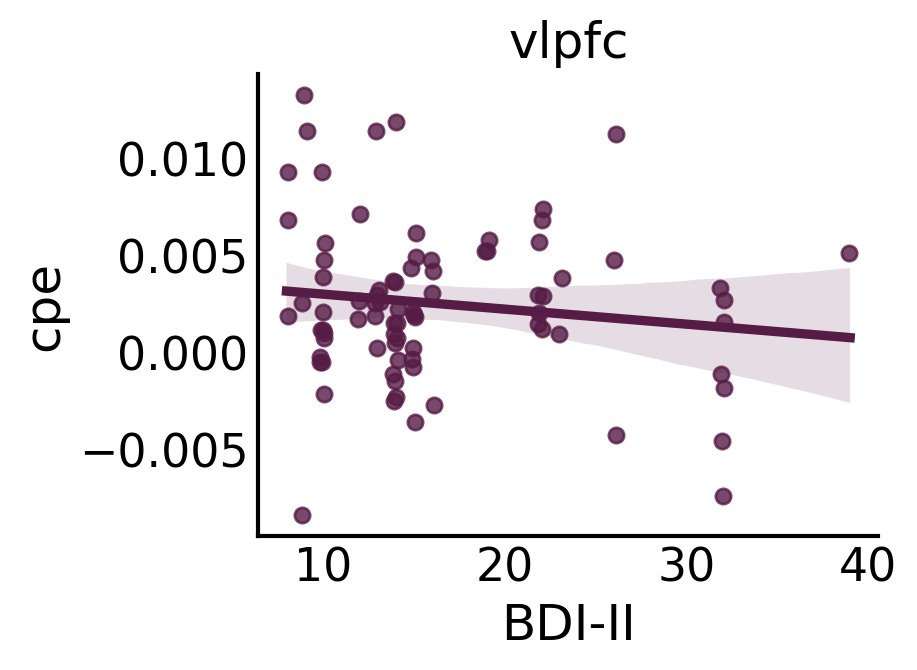

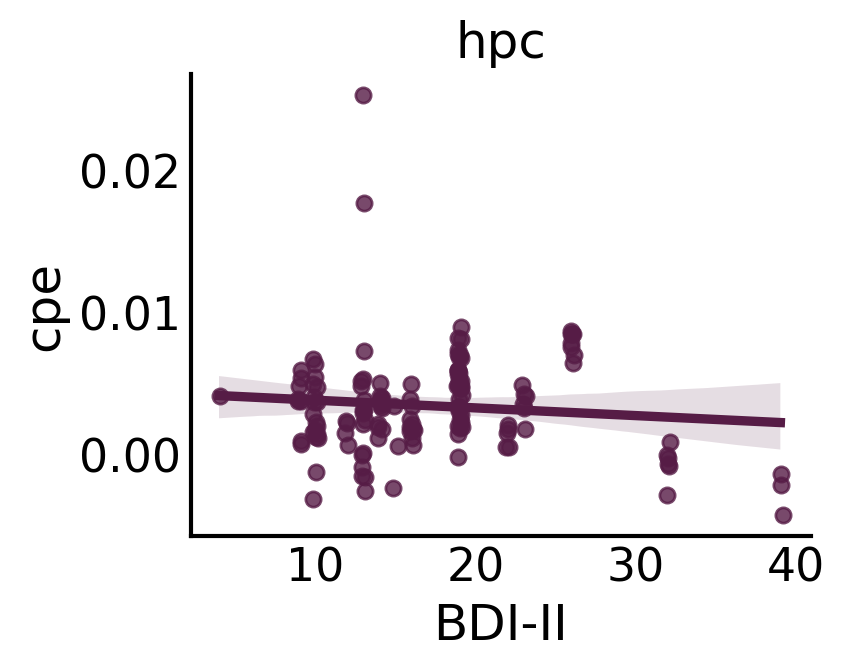

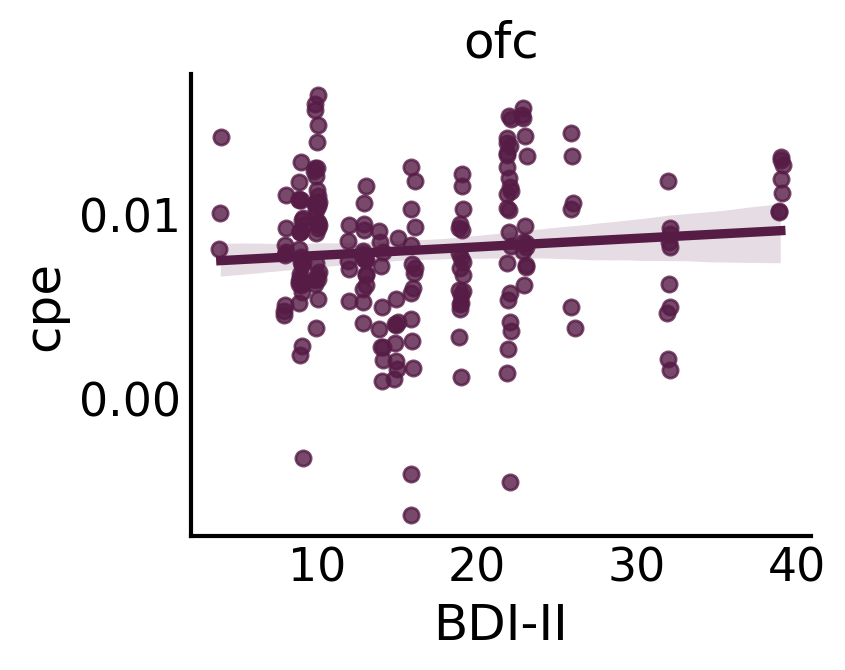

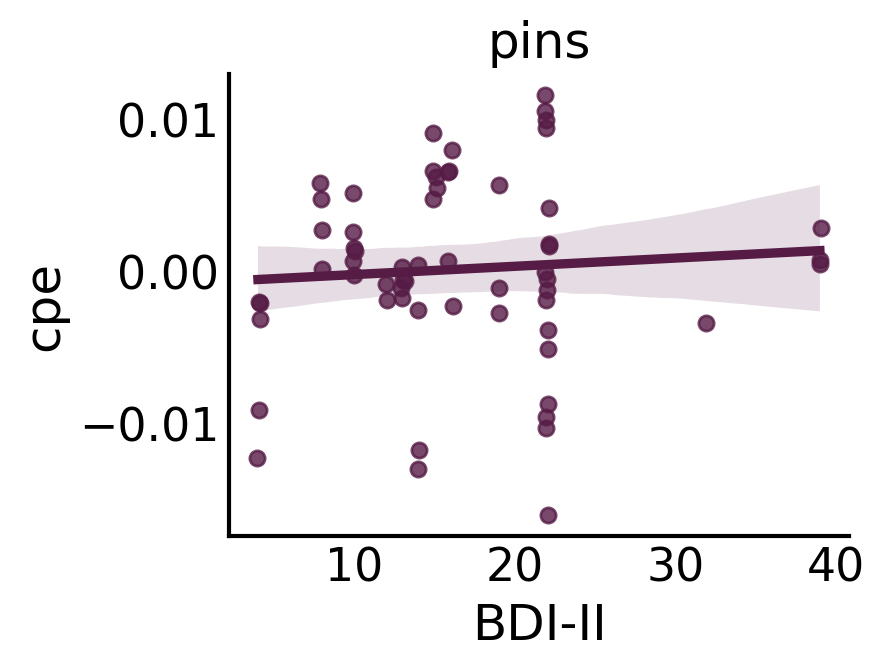

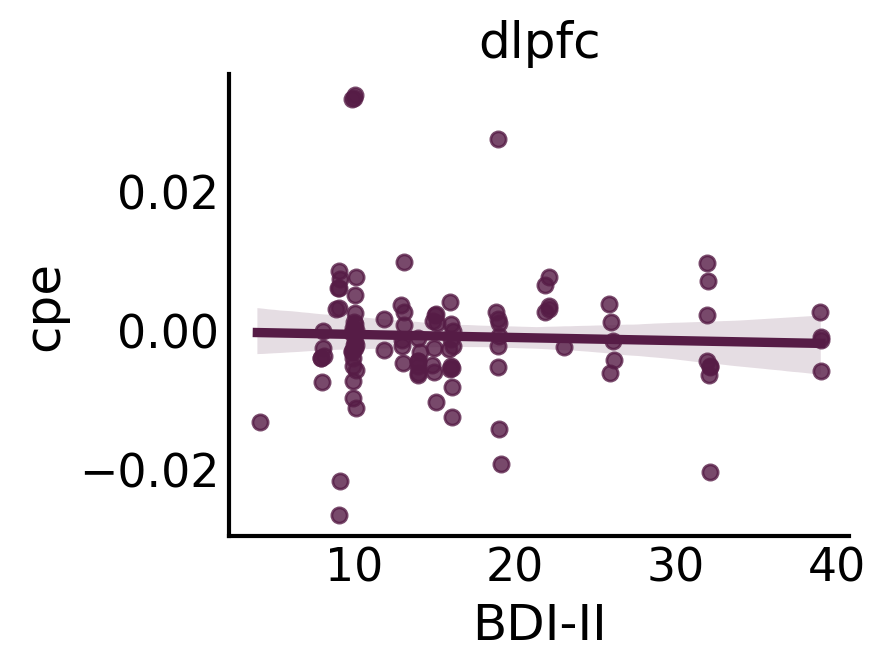

In [61]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='cpe',scatter=True,ci=95,
                fit_reg=True,color = '#561C46',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
    plt.savefig(f'{fig_dir}/{band}_{roi}_{rho}_{rho_p}_roi_bdi-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    